## 1. Imports

Import the libraries to process the data

In [44]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## 2. Read Data

Read in the data for each test result.

In [45]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder
DIRECTORY = "data/page-tracking-test"

# A structure for storing the data
all_data = {}

for i in range(500, 600):
    if os.path.isfile(f"{DIRECTORY}/{i}.csv"):
        all_data[i] = pd.read_csv(f"{DIRECTORY}/{i}.csv")
        print(f"Loaded data for test {i}")

Loaded data for test 500
Loaded data for test 502
Loaded data for test 505
Loaded data for test 508
Loaded data for test 511
Loaded data for test 519
Loaded data for test 523
Loaded data for test 525
Loaded data for test 526
Loaded data for test 531
Loaded data for test 538
Loaded data for test 541
Loaded data for test 544
Loaded data for test 549
Loaded data for test 557


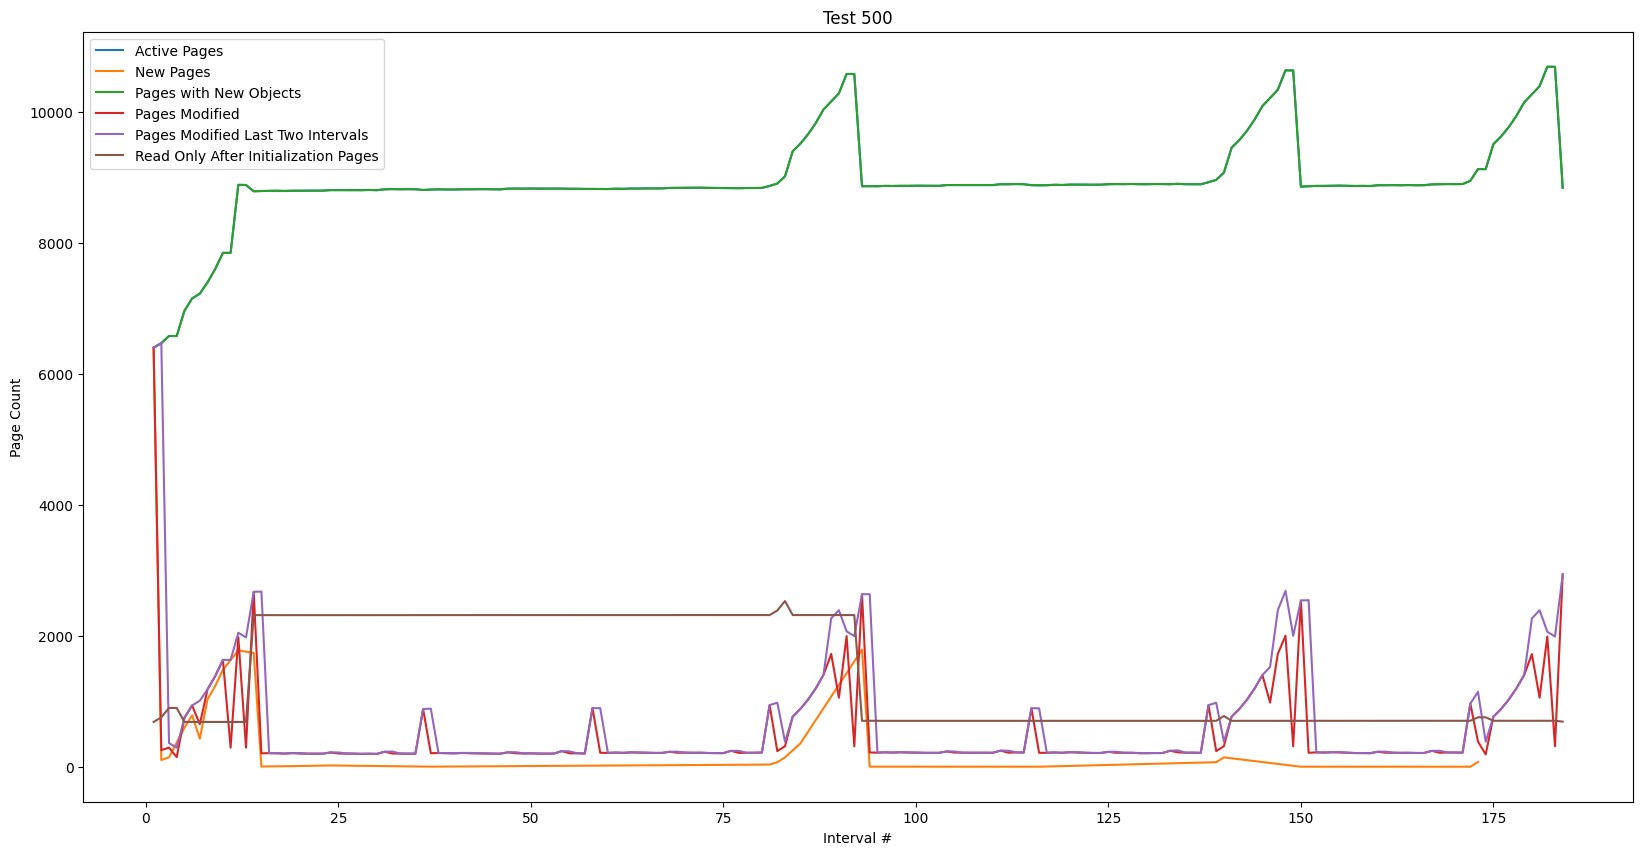

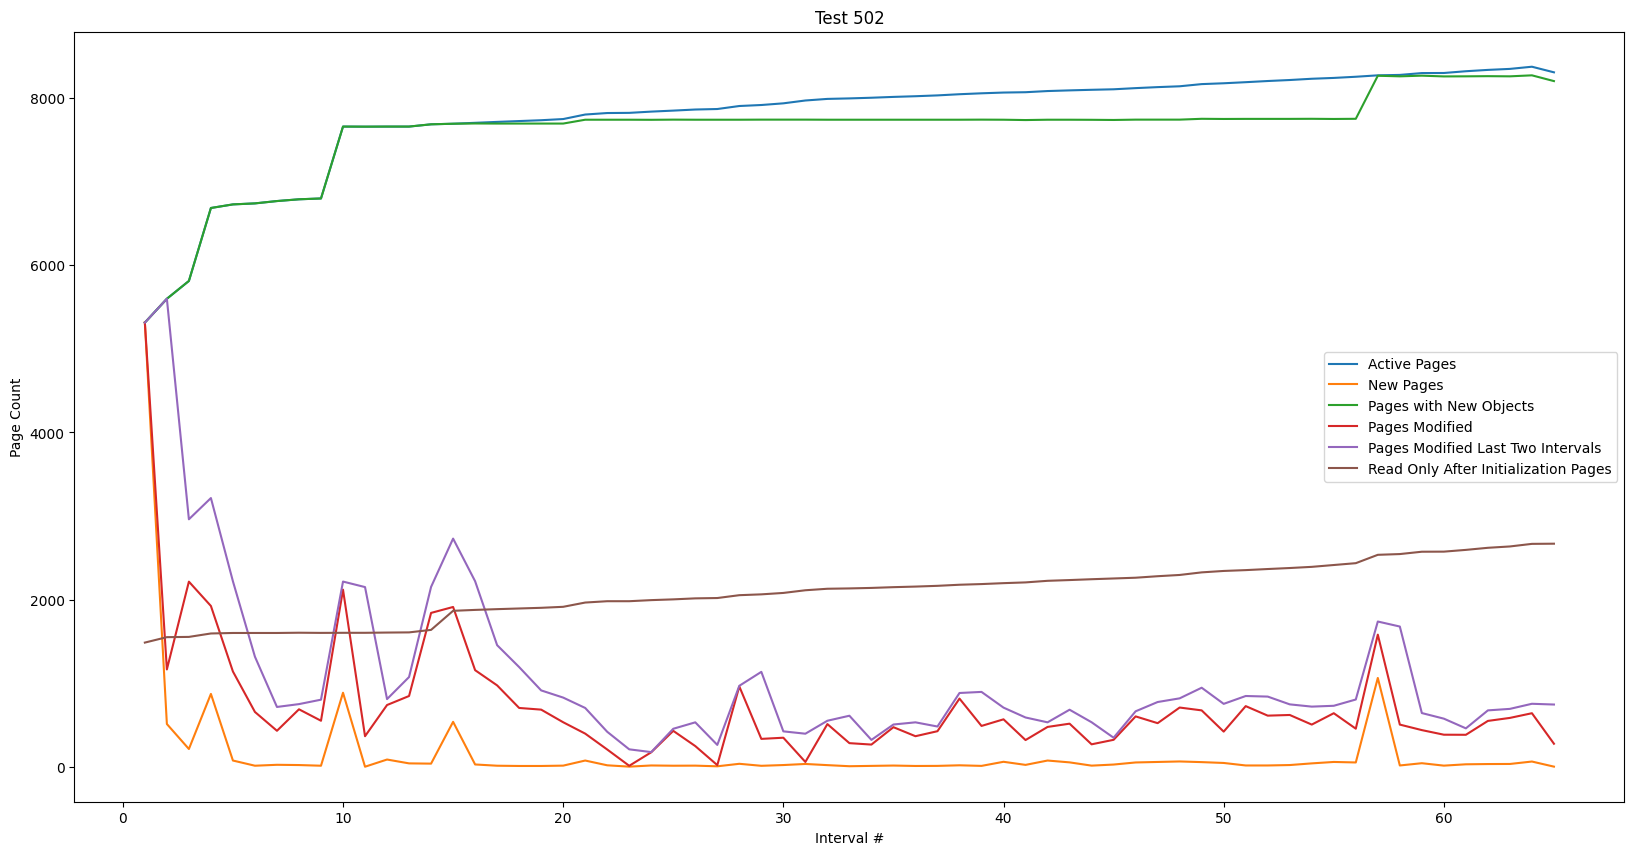

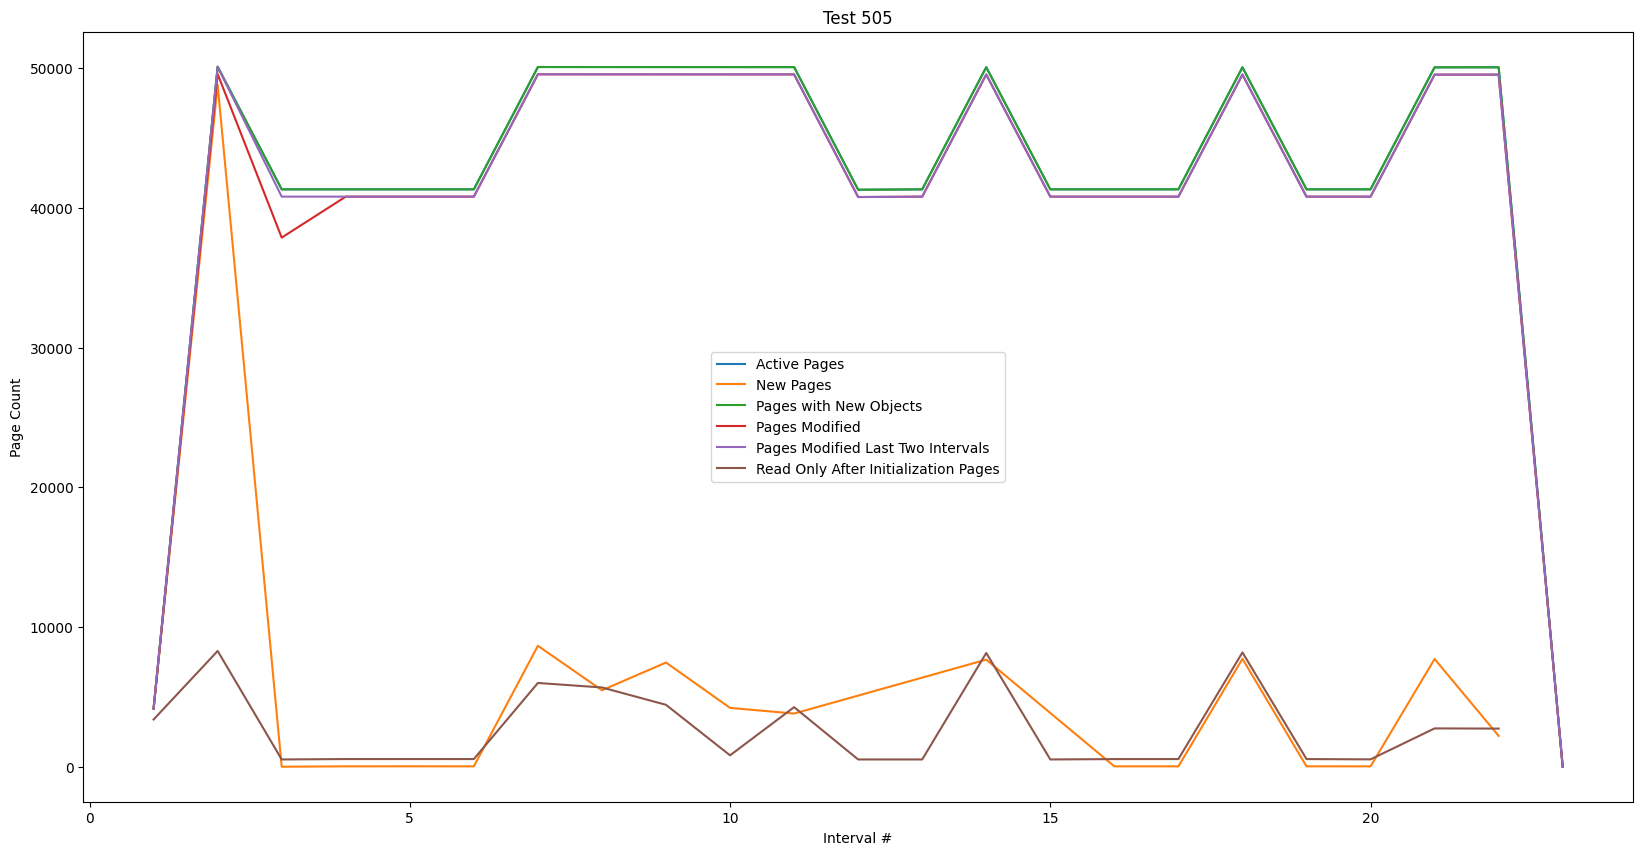

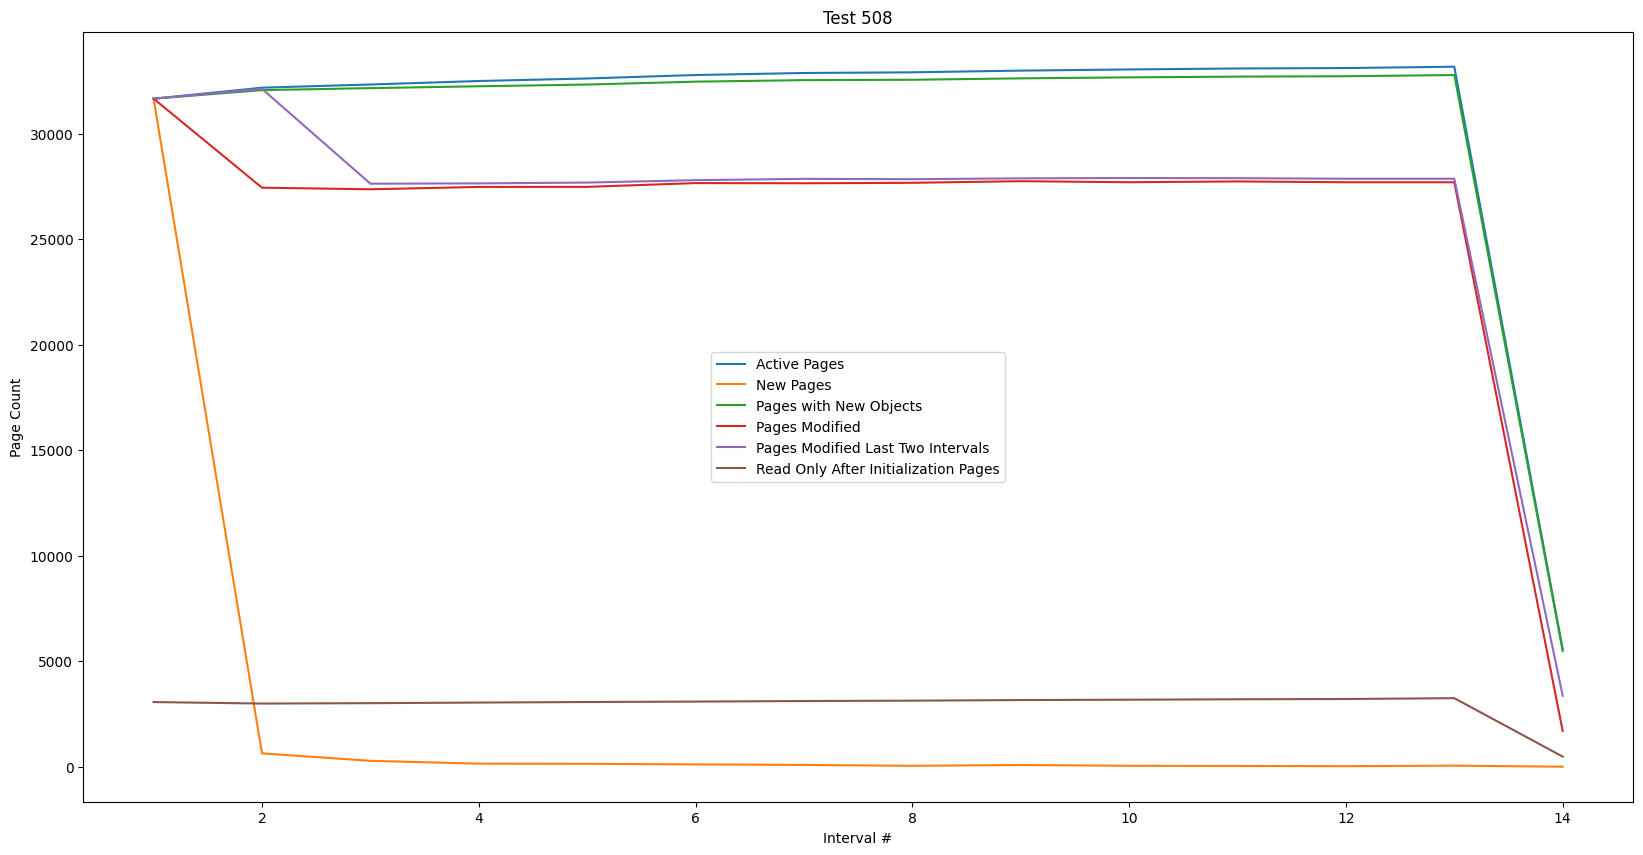

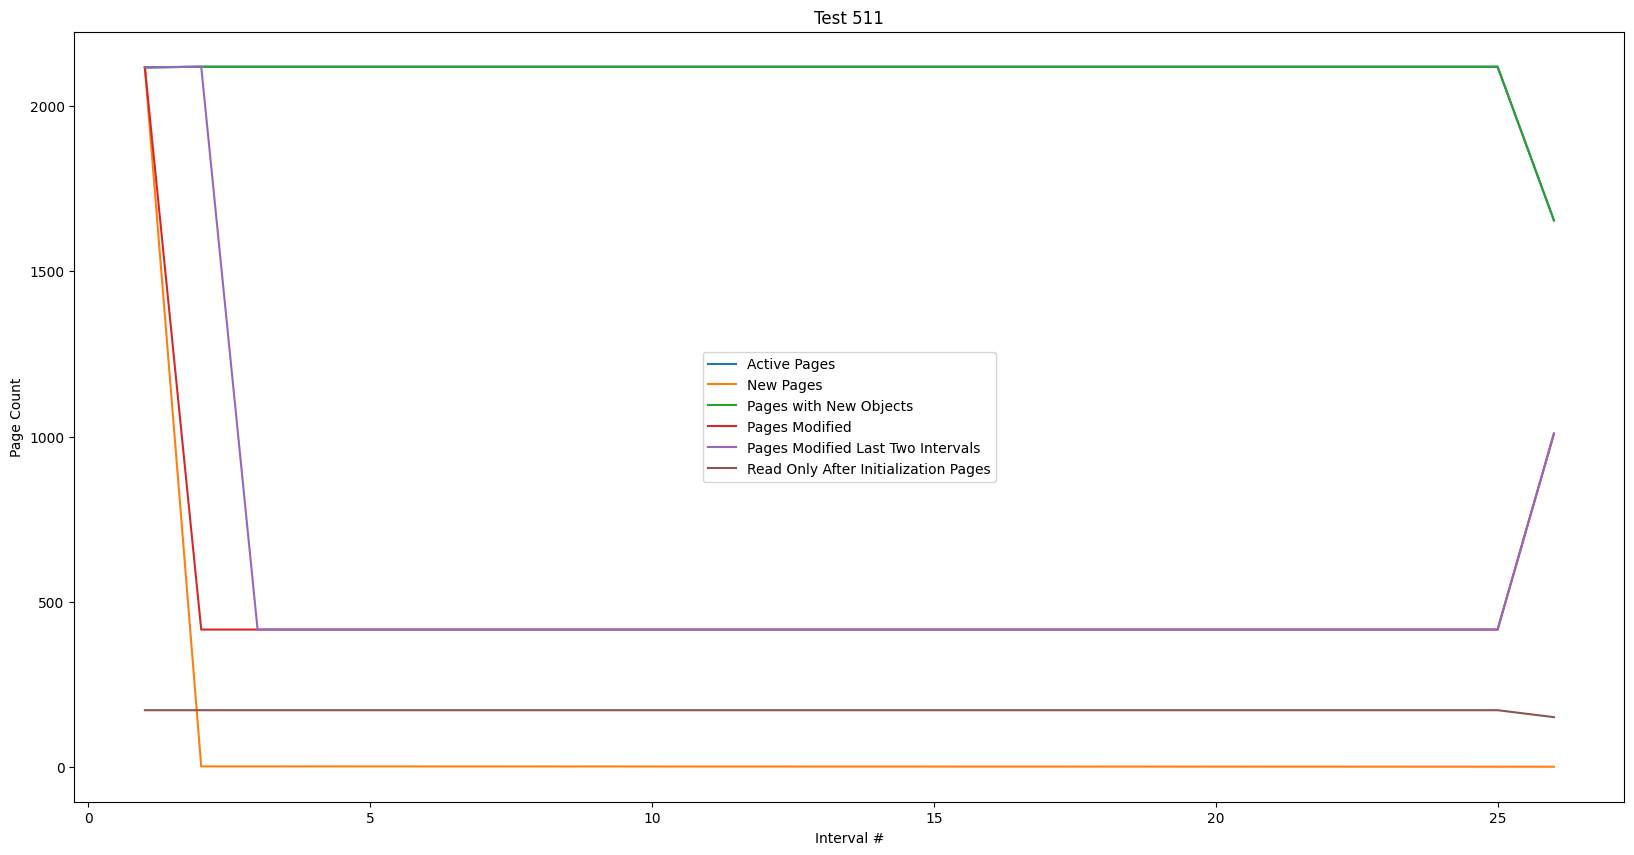

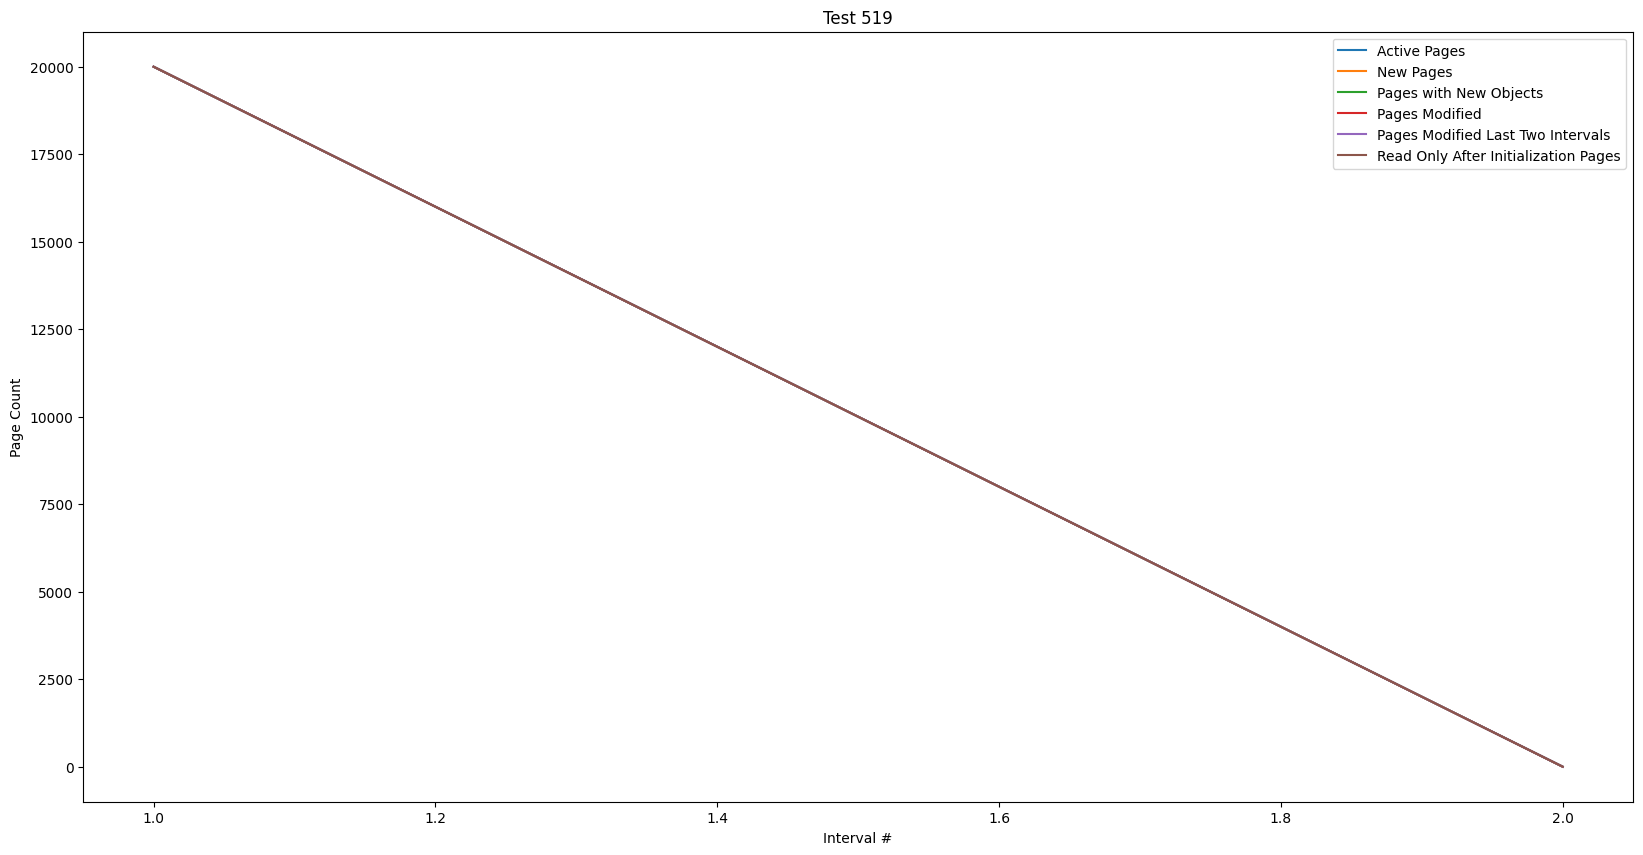

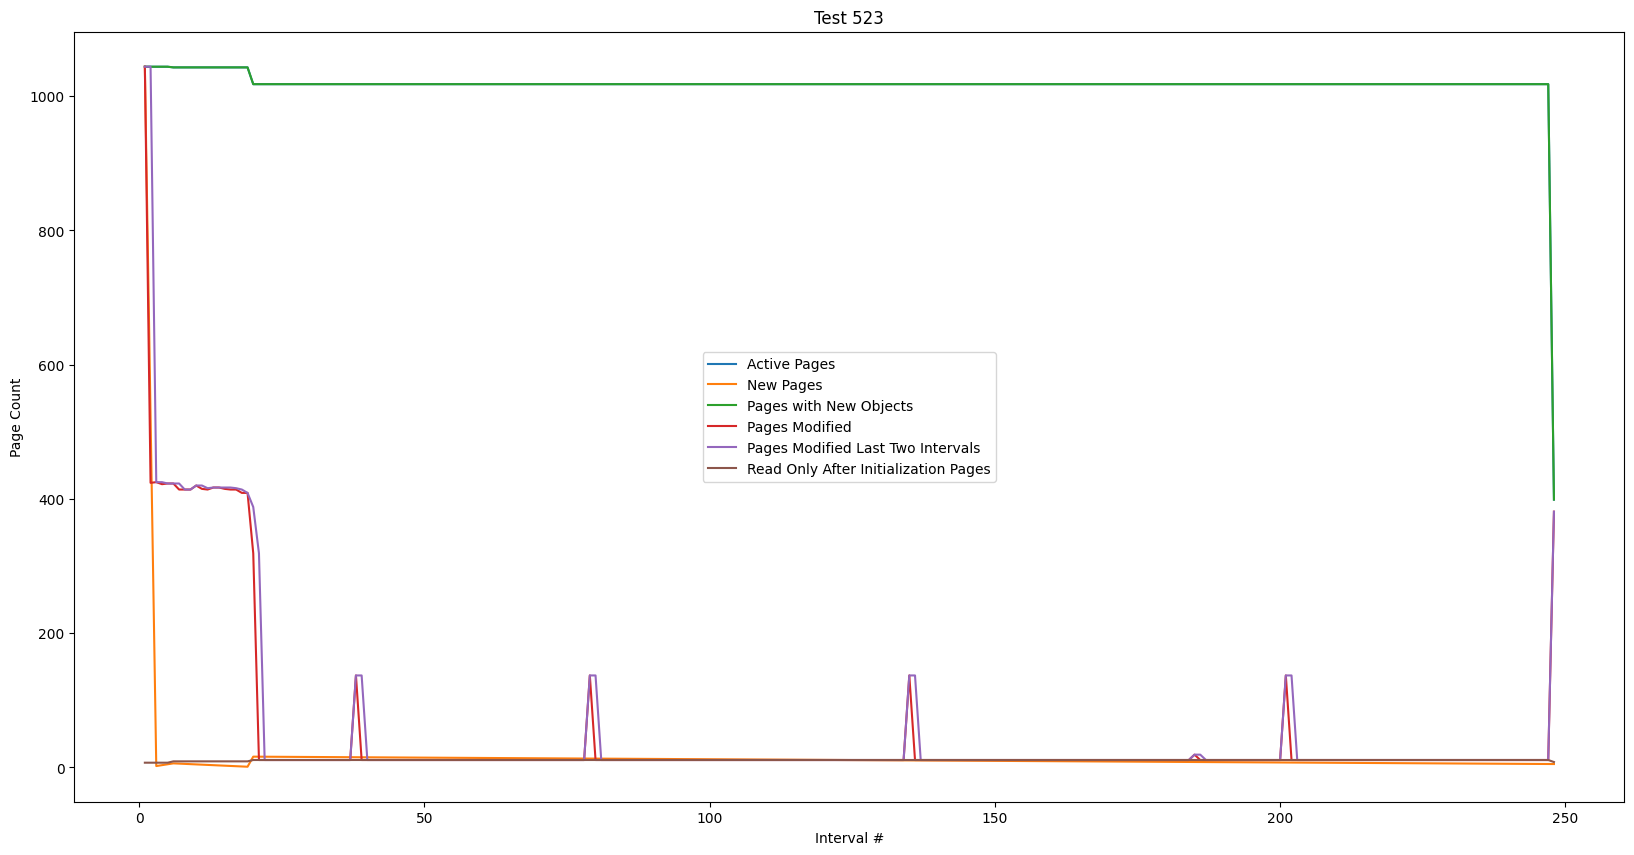

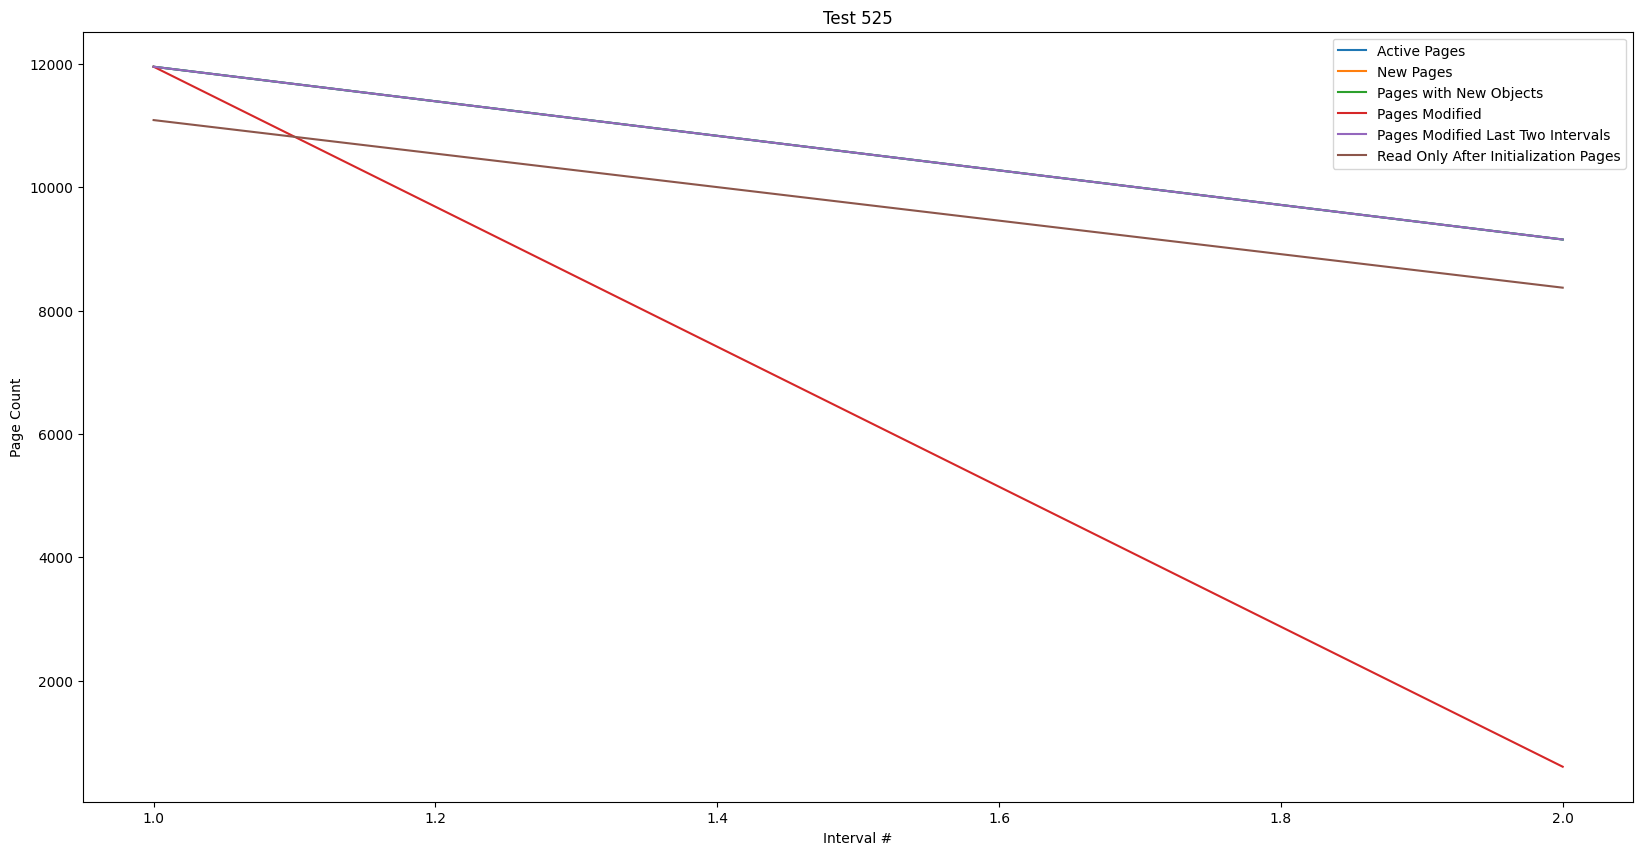

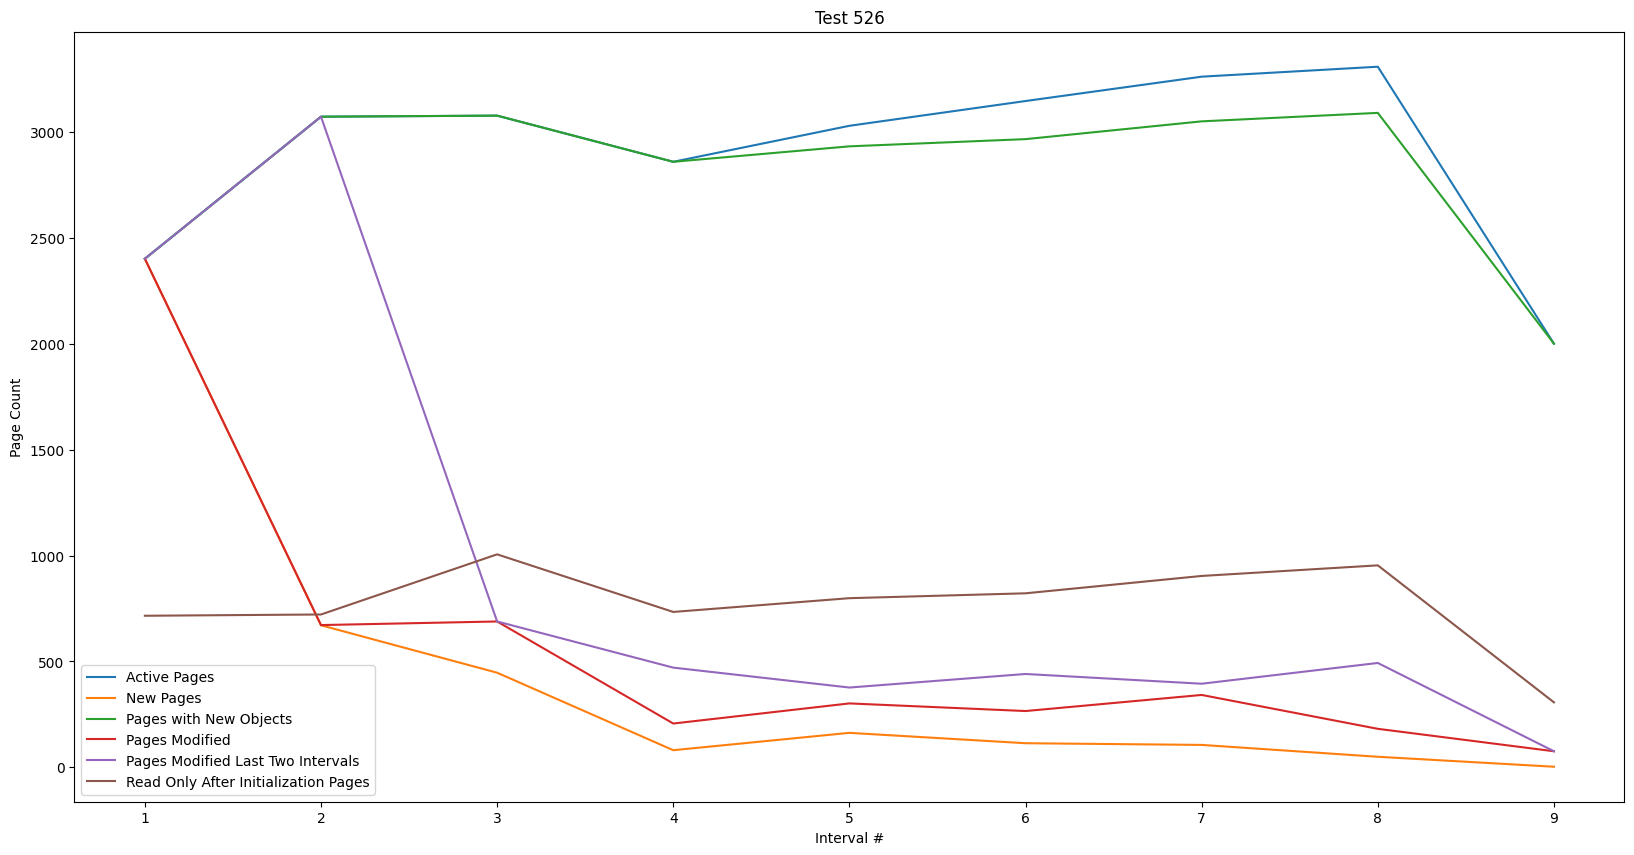

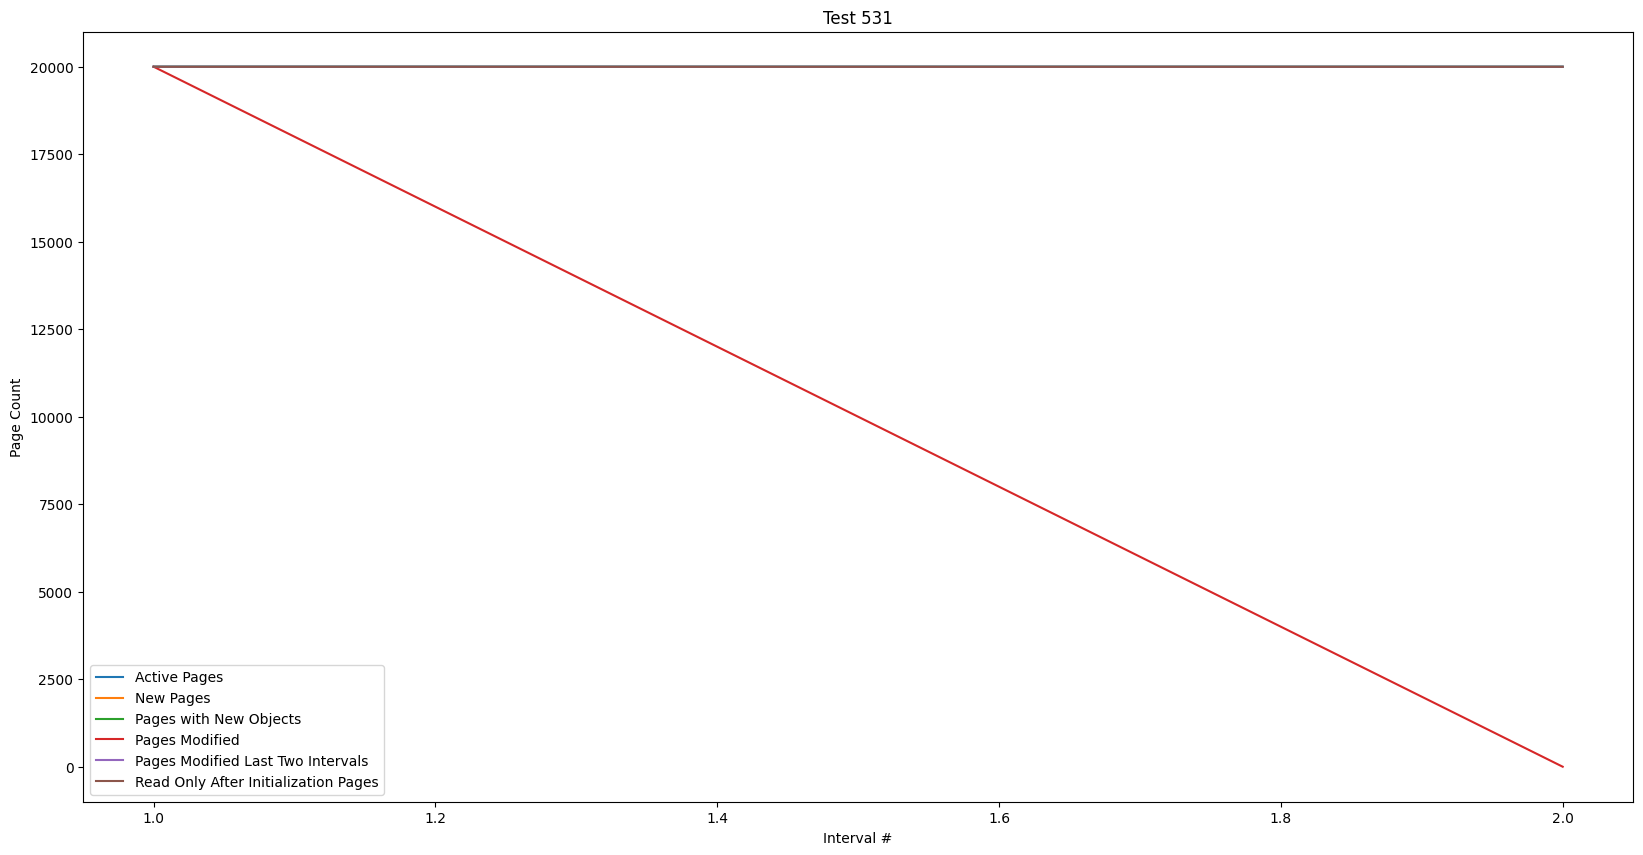

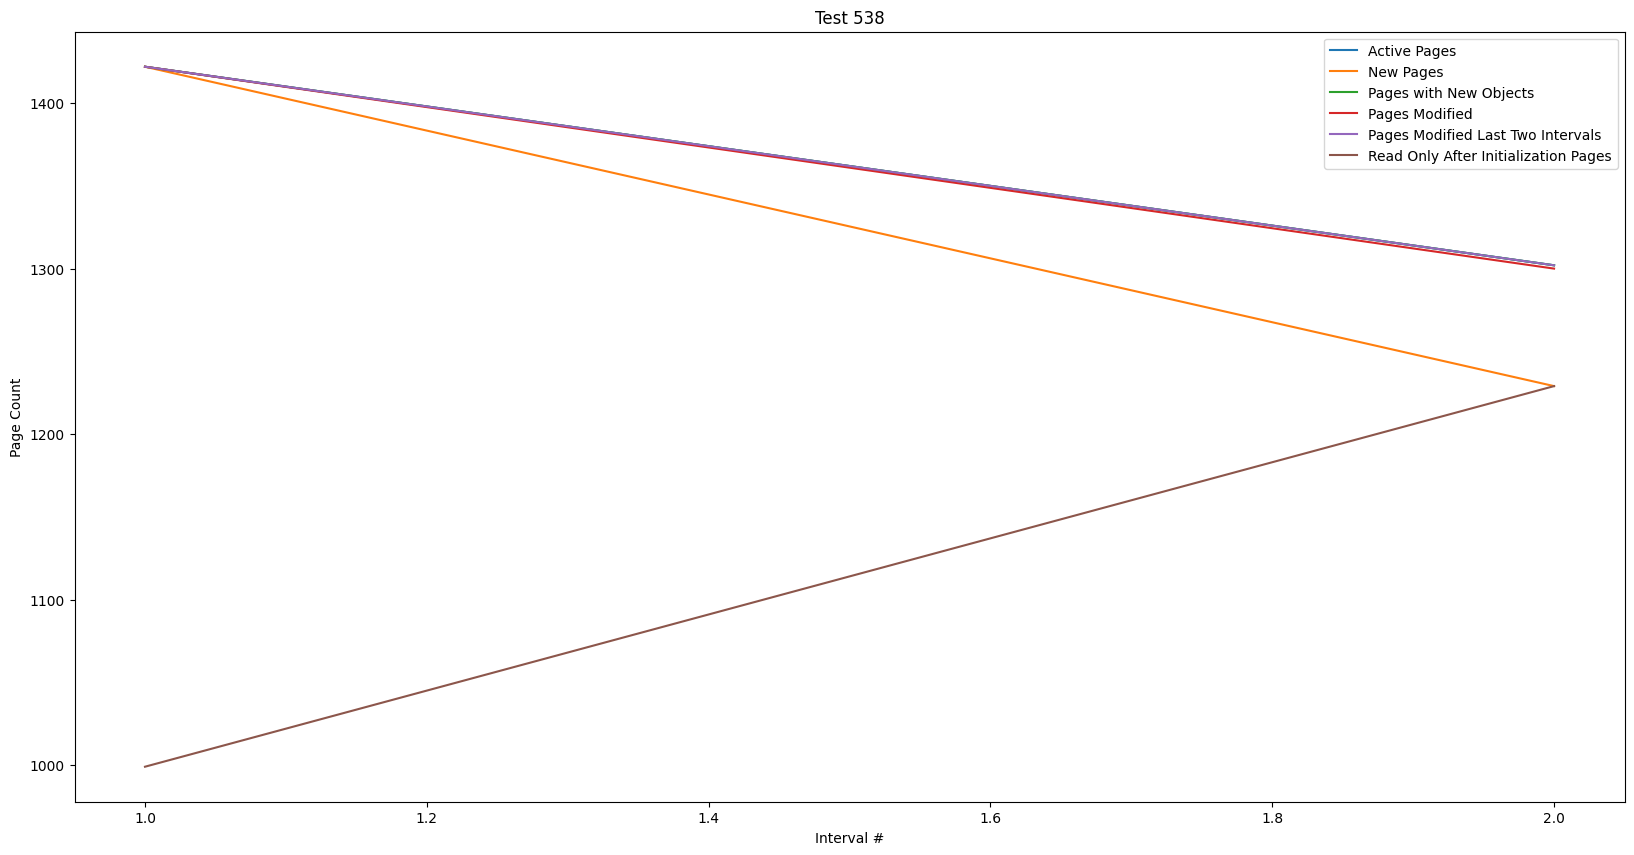

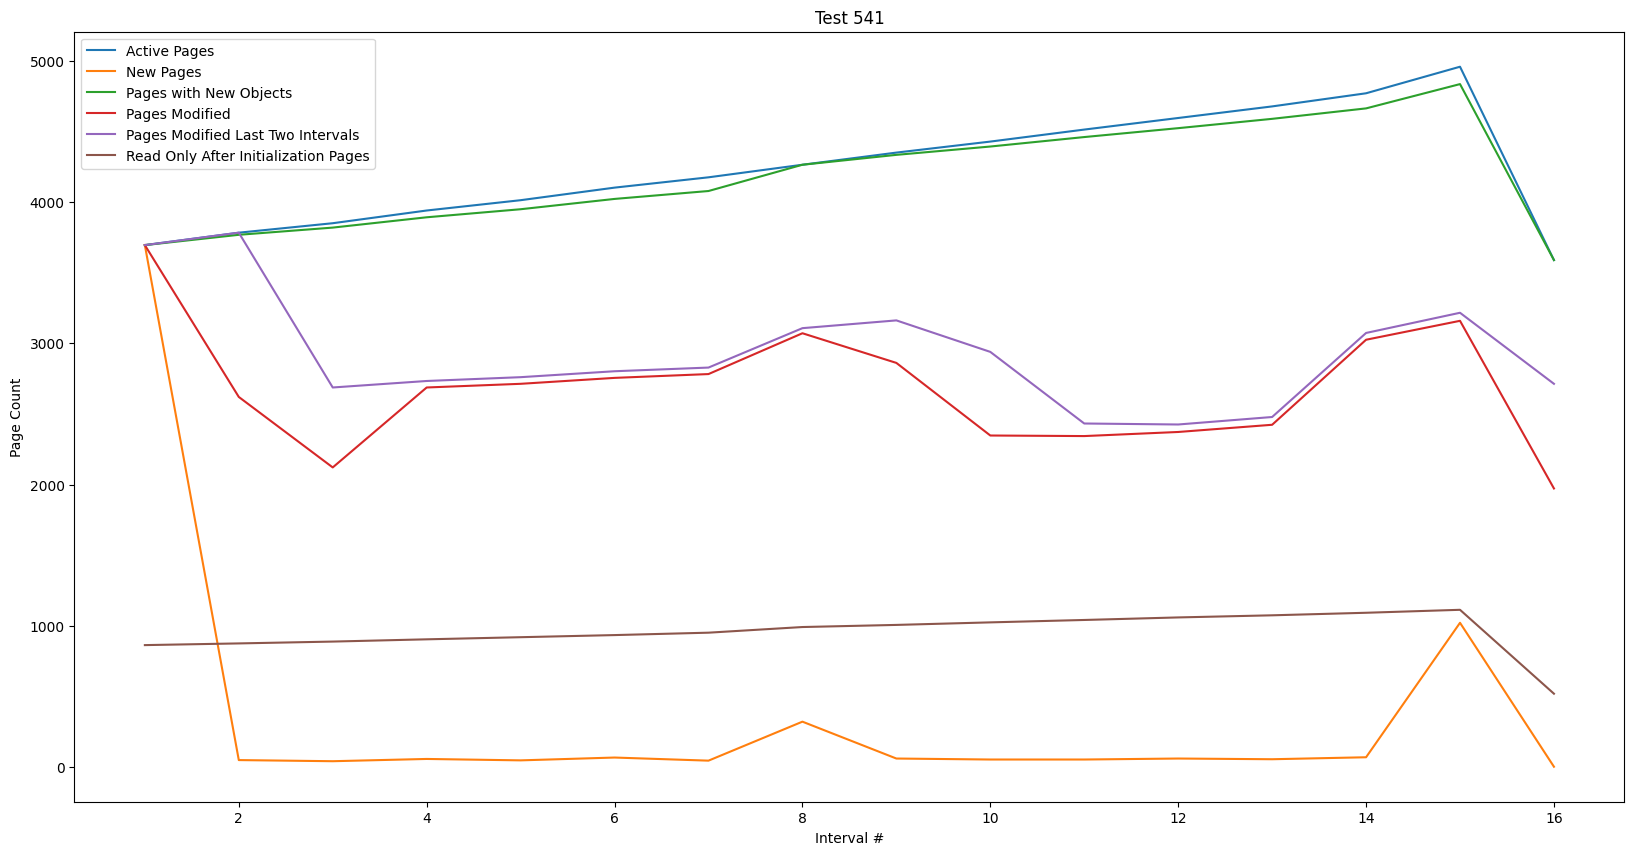

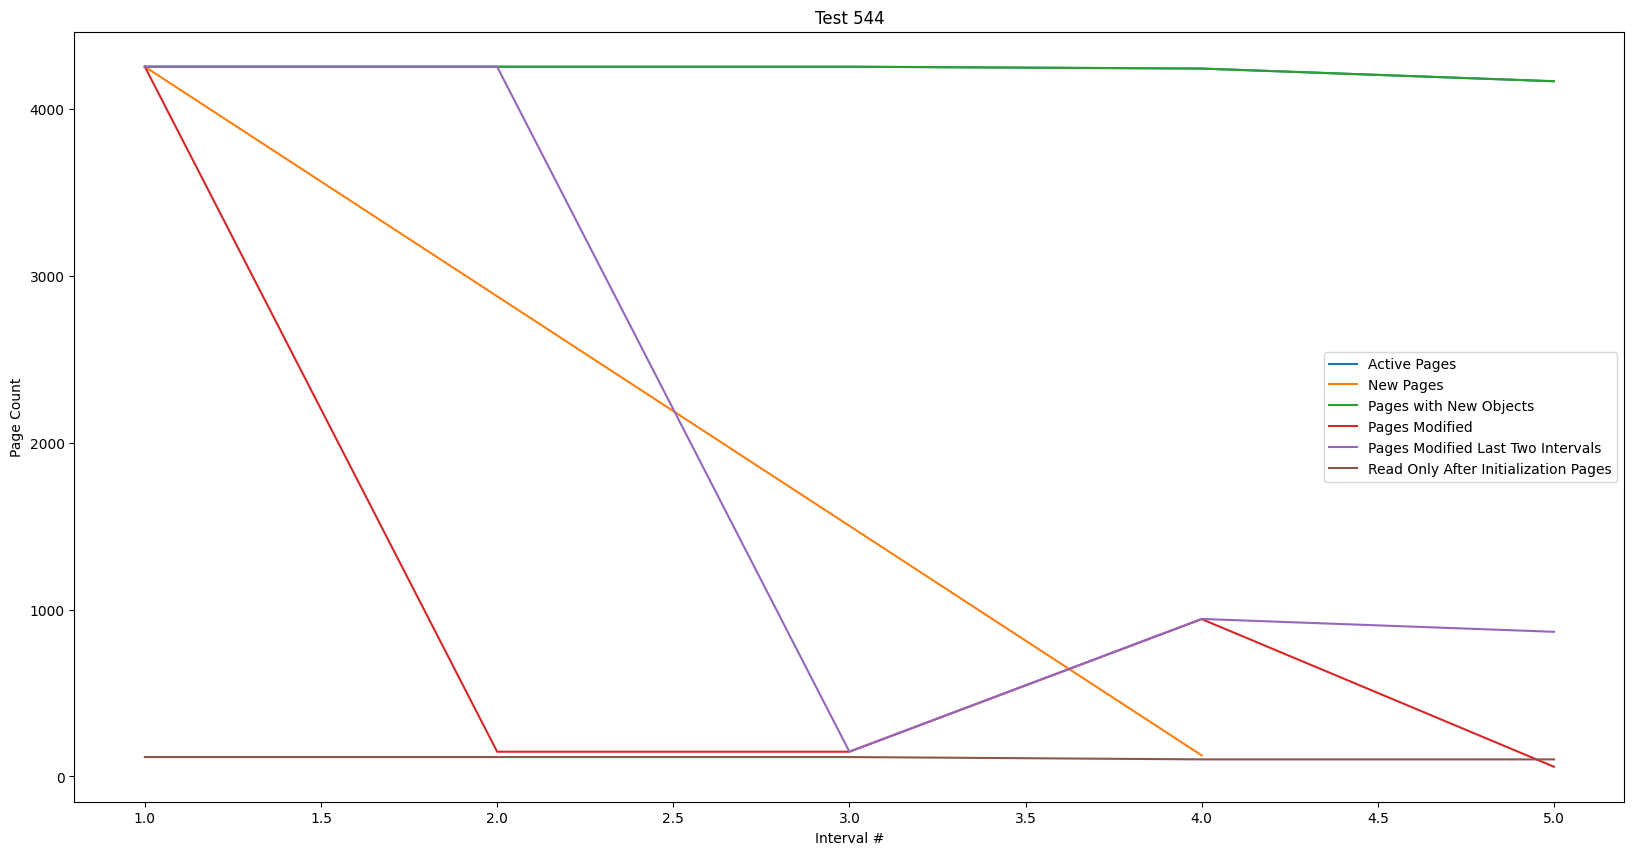

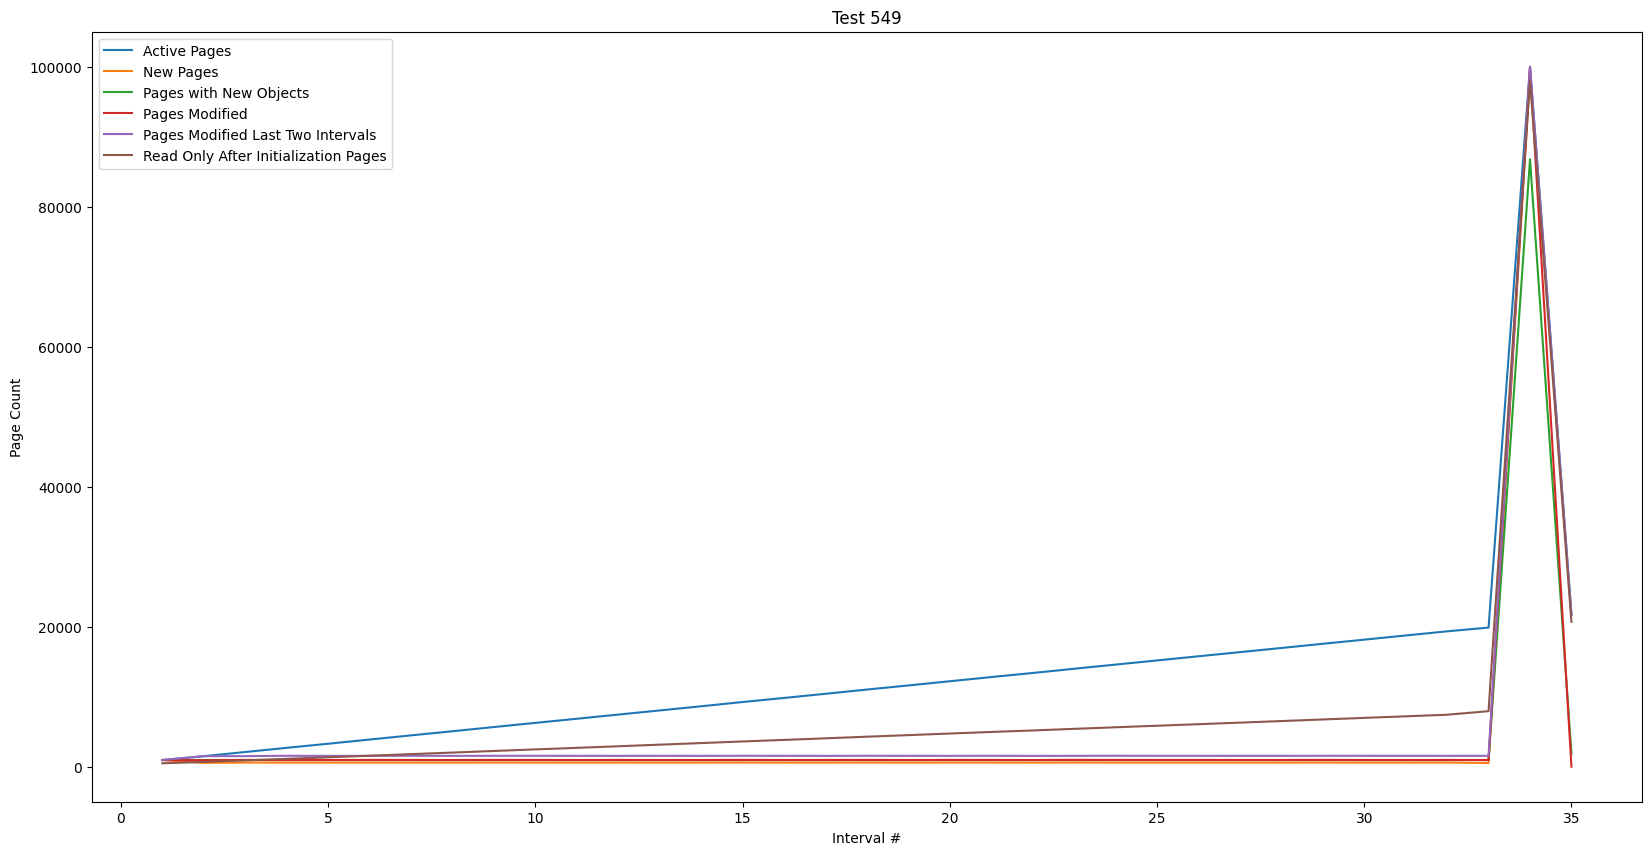

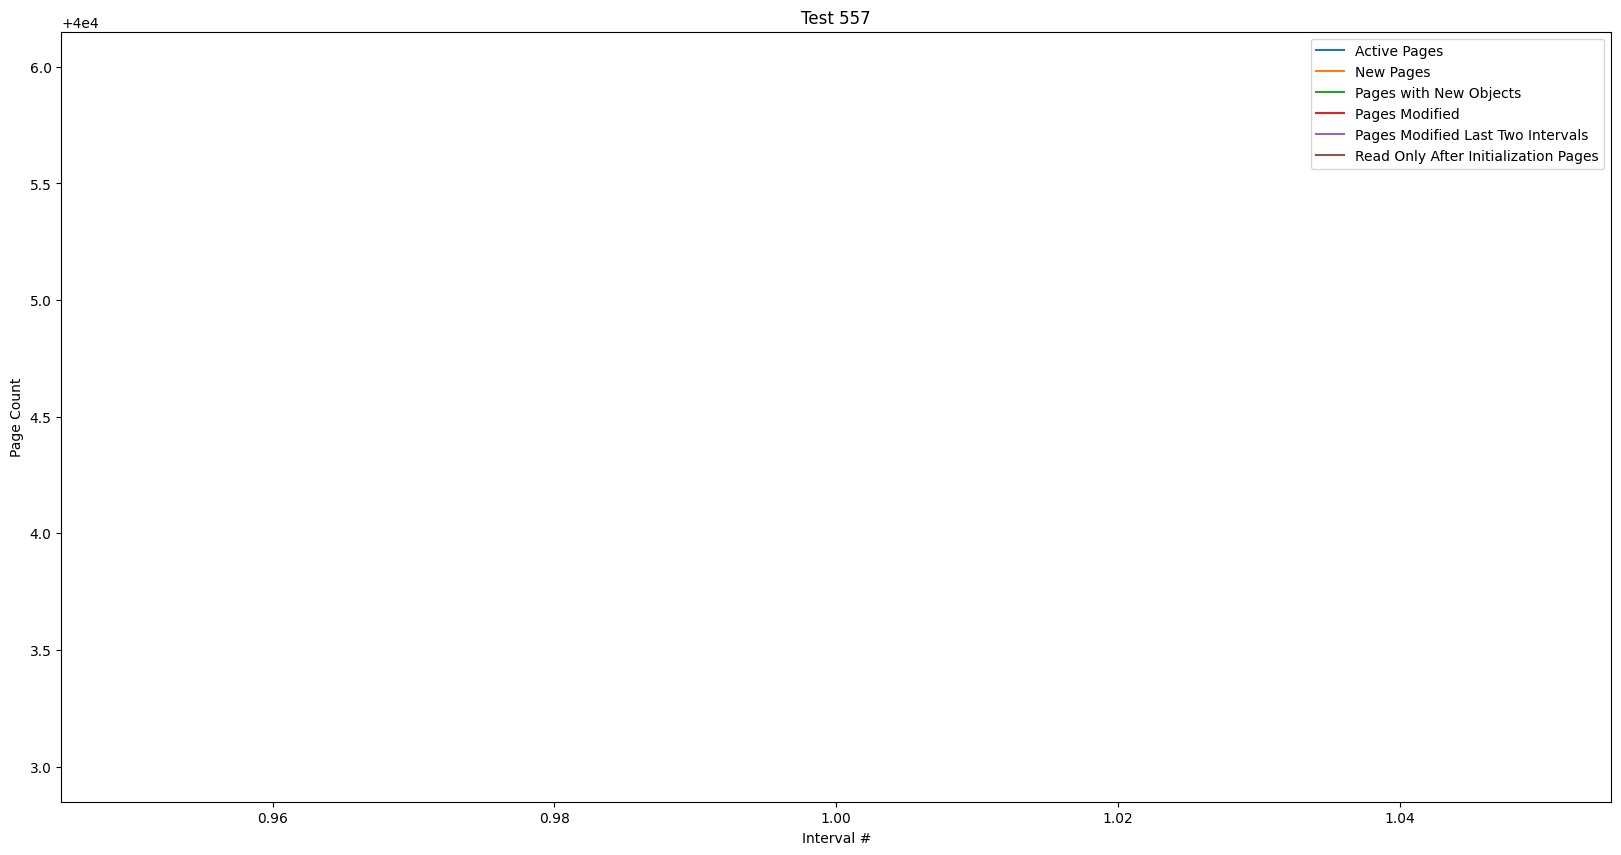

In [46]:
# Show a line graph with a line for:
# Number of active pages (for each interval)
# New pages (for each interval)
# Pages with new objects
# Pages modified
# Pages that have been modified for either of the last two intervals
# Pages that have only been initialized, then not modified

for test in all_data:
    # The data for the test
    test_data = all_data[test]

    plt.figure(figsize=(20,10))
    plt.title(f"Test {test}")
    # Show the number of active pages

    # Sum the entries for each interval
    active_pages = test_data["Interval #"].value_counts().sort_index()

    # The number of new pages
    new_pages = test_data["Interval #"][test_data["Is New Page?"]].value_counts().sort_index()

    # The number of pages with new objects
    new_objects = test_data["Interval #"][test_data["Has New Objects?"]].value_counts().sort_index()

    # The number of pages modified this interval
    modified_pages = test_data["Interval #"][test_data["Modified This Interval?"]].value_counts().sort_index()

    # The number of pages modified in the last two intervals
    modified_last_two = test_data["Interval #"][test_data["Modified This Interval?"] | test_data["Modified Last Interval?"]].value_counts().sort_index()
    
    not_modified = test_data["Interval #"][~test_data["Modified This Interval?"]].value_counts().sort_index()
    not_modified_last_two = test_data["Interval #"][~test_data["Modified This Interval?"] & ~test_data["Modified Last Interval?"]].value_counts().sort_index()
    

    # The number of pages that have only been initialized, then not modified
    # This is only the pages that ONLY EVER have `Write Count` of 1

    # Get all the pages that only ever have a `Write Count` of 1
    read_only = test_data.groupby("Physical Page Address").filter(lambda x: (x['Write Count'] != 2).all())
    # Get the read only pages back into a series
    read_only = read_only["Interval #"].value_counts().sort_index()

    # Plot the data
    sns.lineplot(data=active_pages, label="Active Pages")
    sns.lineplot(data=new_pages, label="New Pages")
    sns.lineplot(data=new_objects, label="Pages with New Objects")
    sns.lineplot(data=modified_pages, label="Pages Modified")
    sns.lineplot(data=modified_last_two, label="Pages Modified Last Two Intervals")
    sns.lineplot(data=not_modified, label="Pages Not Modified")
    sns.lineplot(data=not_modified_last_two, label="Pages Not Modified Last Two Intervals")
    sns.lineplot(data=read_only, label="Read Only After Initialization Pages")
    plt.xlabel("Interval #")
    plt.ylabel("Page Count")

    plt.legend()
    plt.show()


In [47]:
# The data is stored in a 5XX.csv for the serial tests, and 6XX.csv for the parallel tests
# The data files are in the `/data` folder

DIRECTORY = "data/page-liveness-test"

# A structure for storing the data
all_data = {}

for i in range(500, 600):
    if os.path.isfile(f"{DIRECTORY}/{i}.csv"):
        all_data[i] = pd.read_csv(f"{DIRECTORY}/{i}.csv")
        print(f"Loaded data for test {i}")

Loaded data for test 500
Loaded data for test 502
Loaded data for test 505
Loaded data for test 508
Loaded data for test 511
Loaded data for test 519
Loaded data for test 523
Loaded data for test 525
Loaded data for test 526
Loaded data for test 531
Loaded data for test 538
Loaded data for test 541
Loaded data for test 544
Loaded data for test 549
Loaded data for test 557


In [48]:
all_tests = pd.DataFrame()
for test_number in all_data.keys():
    test_data = all_data[test_number]
    # Show a violin graph with the compression ratio for each page throughout all intervals
    # Get the compressed sizes of the pages by getting their compression savings in bytes, and subtracting that from the page size (4096)
    test_data["Compressed Size"] = 4096 - test_data["Compression Savings (bytes)"]
    # Get the compression ratio by dividing the compressed size by the original size
    test_data["Compression Ratio"] = test_data["Compressed Size"] / 4096
    # Add the test number to the data
    test_data["Test Number"] = f"Test #{test_number}"
    
    print("Average compression ratio for test", test_number, ":", test_data["Compression Ratio"].mean())
    print("Average saved bytes for test", test_number, ":", test_data["Compression Savings (bytes)"].mean())
    all_tests = pd.concat([all_tests, test_data])
    print("Done with test", test_number)

Average compression ratio for test 500 : 0.19722062595833245
Average saved bytes for test 500 : 3288.1843160746703
Done with test 500
Average compression ratio for test 502 : 0.14084374866848176
Average saved bytes for test 502 : 3519.104005453899
Done with test 502
Average compression ratio for test 505 : 0.21711748823087837
Average saved bytes for test 505 : 3206.686768206322
Done with test 505
Average compression ratio for test 508 : 0.3137634104323211
Average saved bytes for test 508 : 2810.825070869213
Done with test 508
Average compression ratio for test 511 : 0.19292286977908132
Average saved bytes for test 511 : 3305.787925384883
Done with test 511
Average compression ratio for test 519 : 0.6919143475422331
Average saved bytes for test 519 : 1261.918832467013
Done with test 519
Average compression ratio for test 523 : 0.19561270322717478
Average saved bytes for test 523 : 3294.7703675814923
Done with test 523
Average compression ratio for test 525 : 0.5857604584305562
Average s

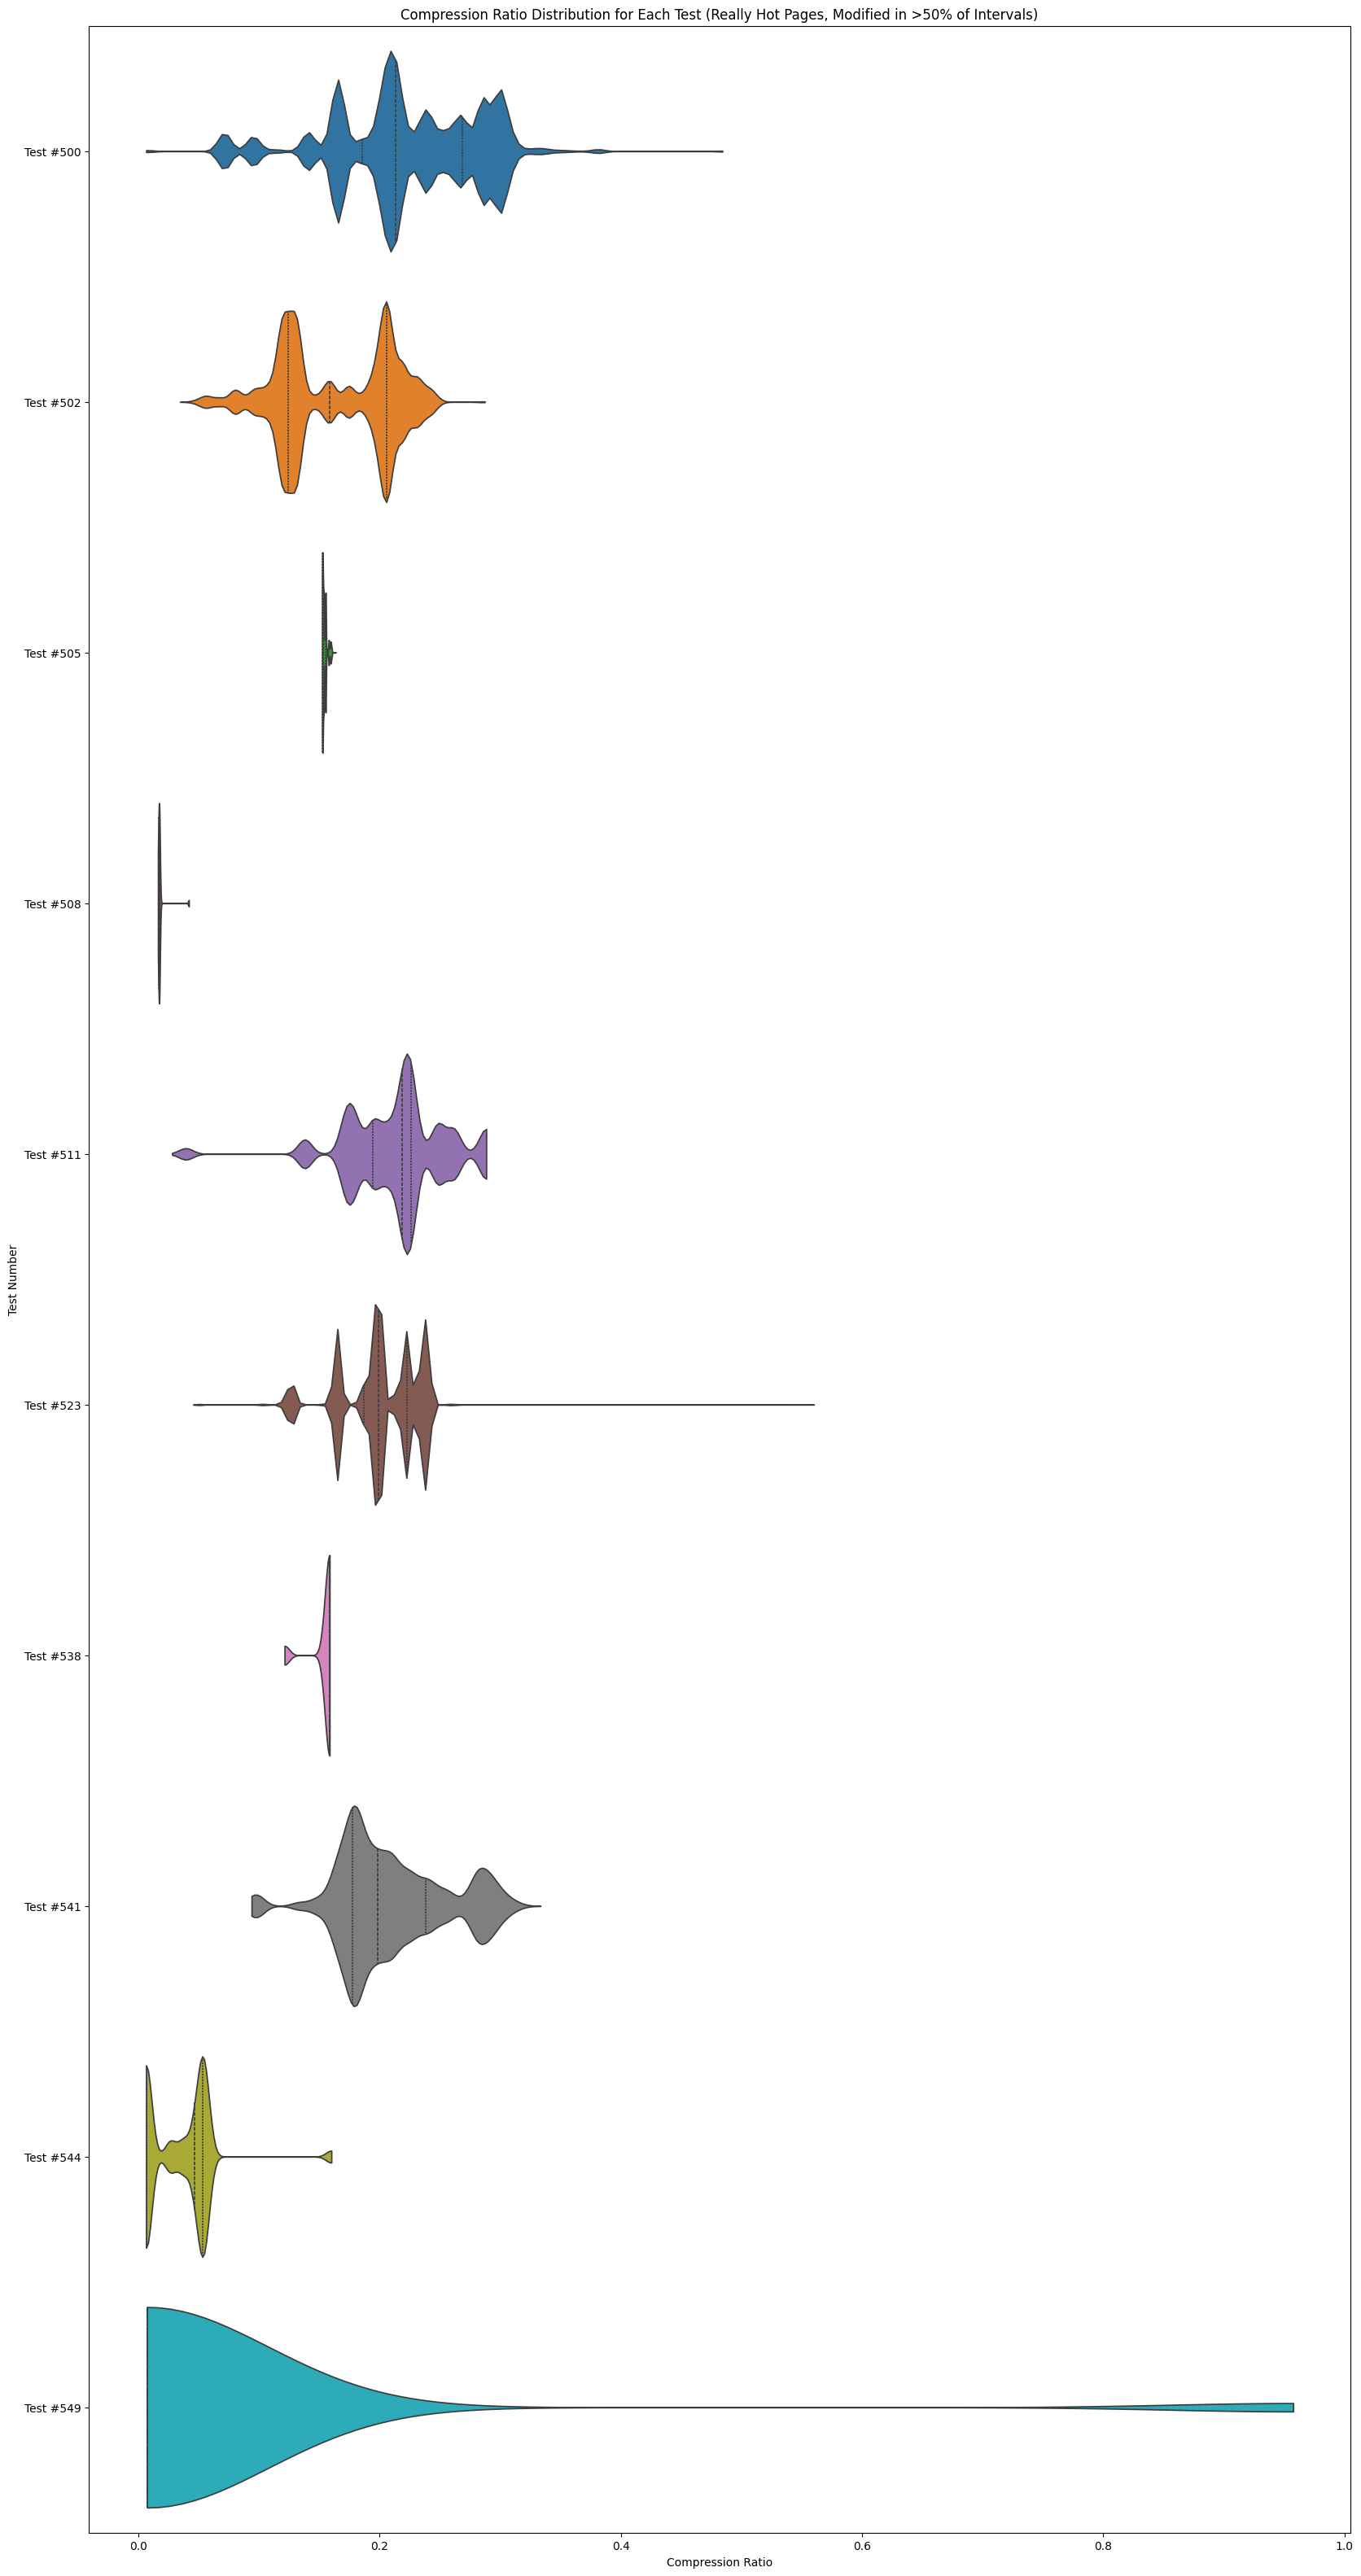

In [49]:
plt.figure(figsize=(20, 40))
# Get only the pages that are modified for less than 20% of the intervals
intervals = all_tests["Interval #"].max()
hot_pages = all_tests.groupby("Physical Page Address").filter(lambda x: (x["Written During This Interval?"].sum() / intervals) > 0.5)

ax = sns.violinplot(data=hot_pages, cut=0, x="Compression Ratio", y="Test Number", hue="Test Number", inner="quartile")
# Label with the test number

plt.xlabel("Compression Ratio")
plt.ylabel("Test Number")
plt.title("Compression Ratio Distribution for Each Test (Really Hot Pages, Modified in >50% of Intervals)")
plt.show()

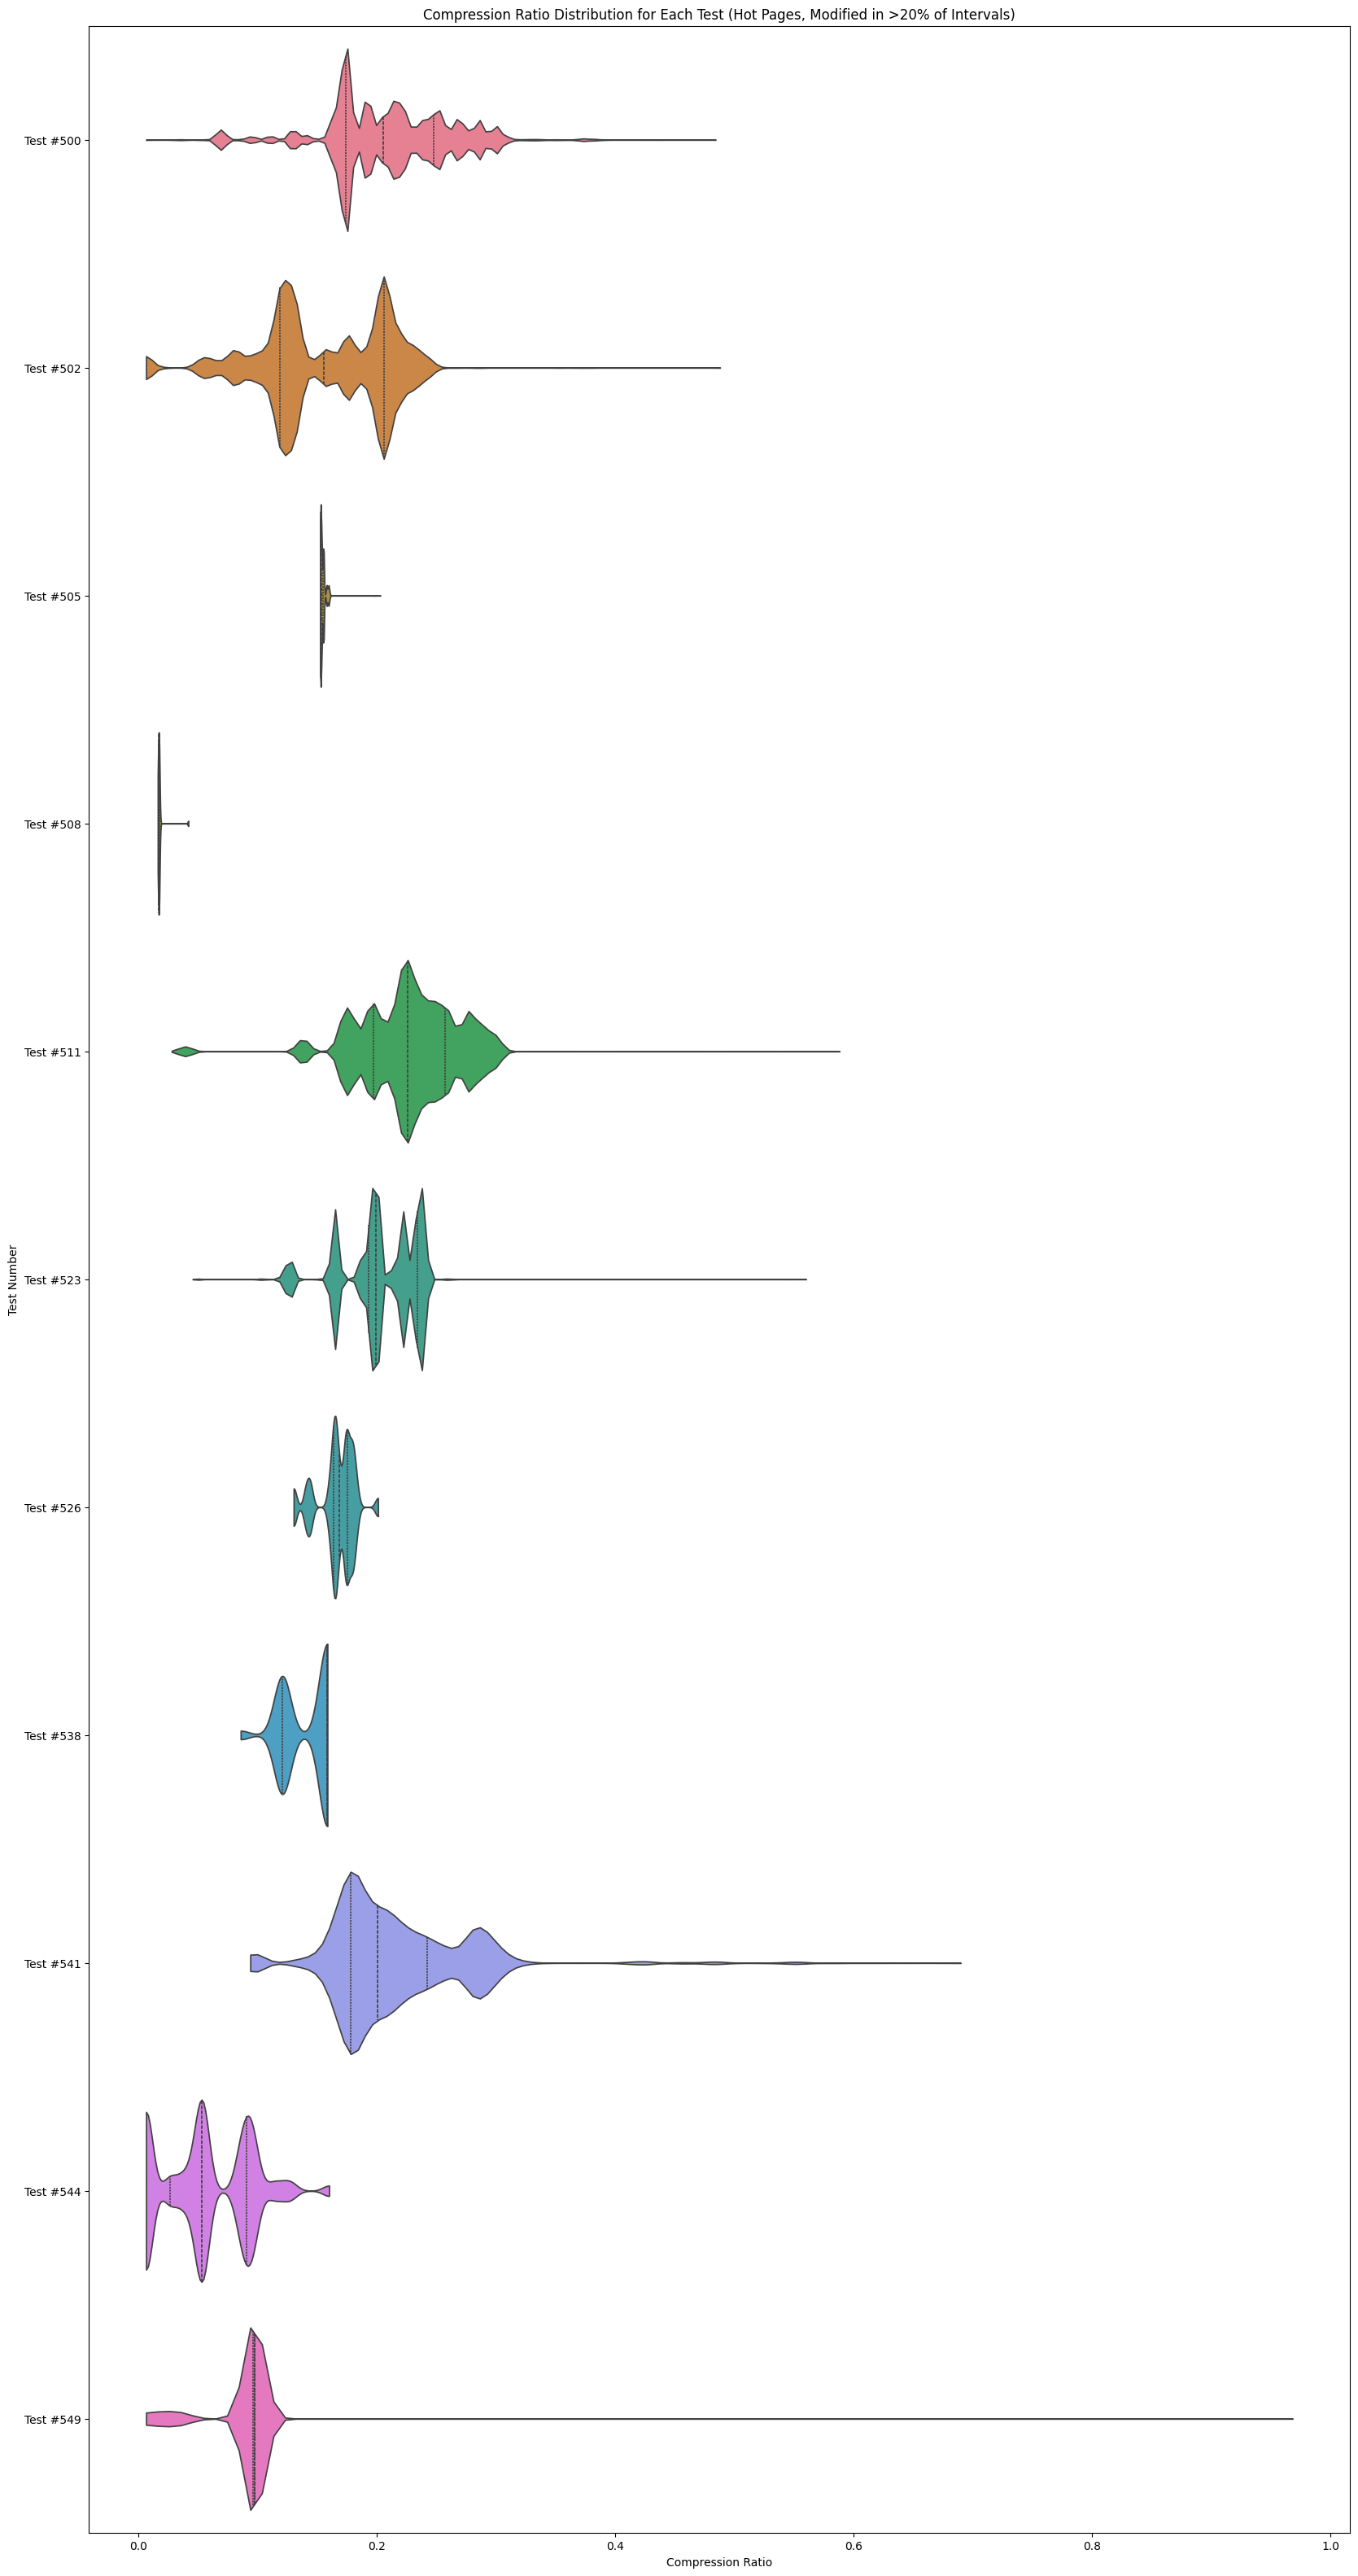

In [50]:
plt.figure(figsize=(20, 40))
# Get only the pages that are modified for less than 20% of the intervals
intervals = all_tests["Interval #"].max()
hot_pages = all_tests.groupby("Physical Page Address").filter(lambda x: (x["Written During This Interval?"].sum() / intervals) > 0.2)

ax = sns.violinplot(data=hot_pages, cut=0, x="Compression Ratio", y="Test Number", hue="Test Number", inner="quartile")
# Label with the test number

plt.xlabel("Compression Ratio")
plt.ylabel("Test Number")
plt.title("Compression Ratio Distribution for Each Test (Hot Pages, Modified in >20% of Intervals)")
plt.show()

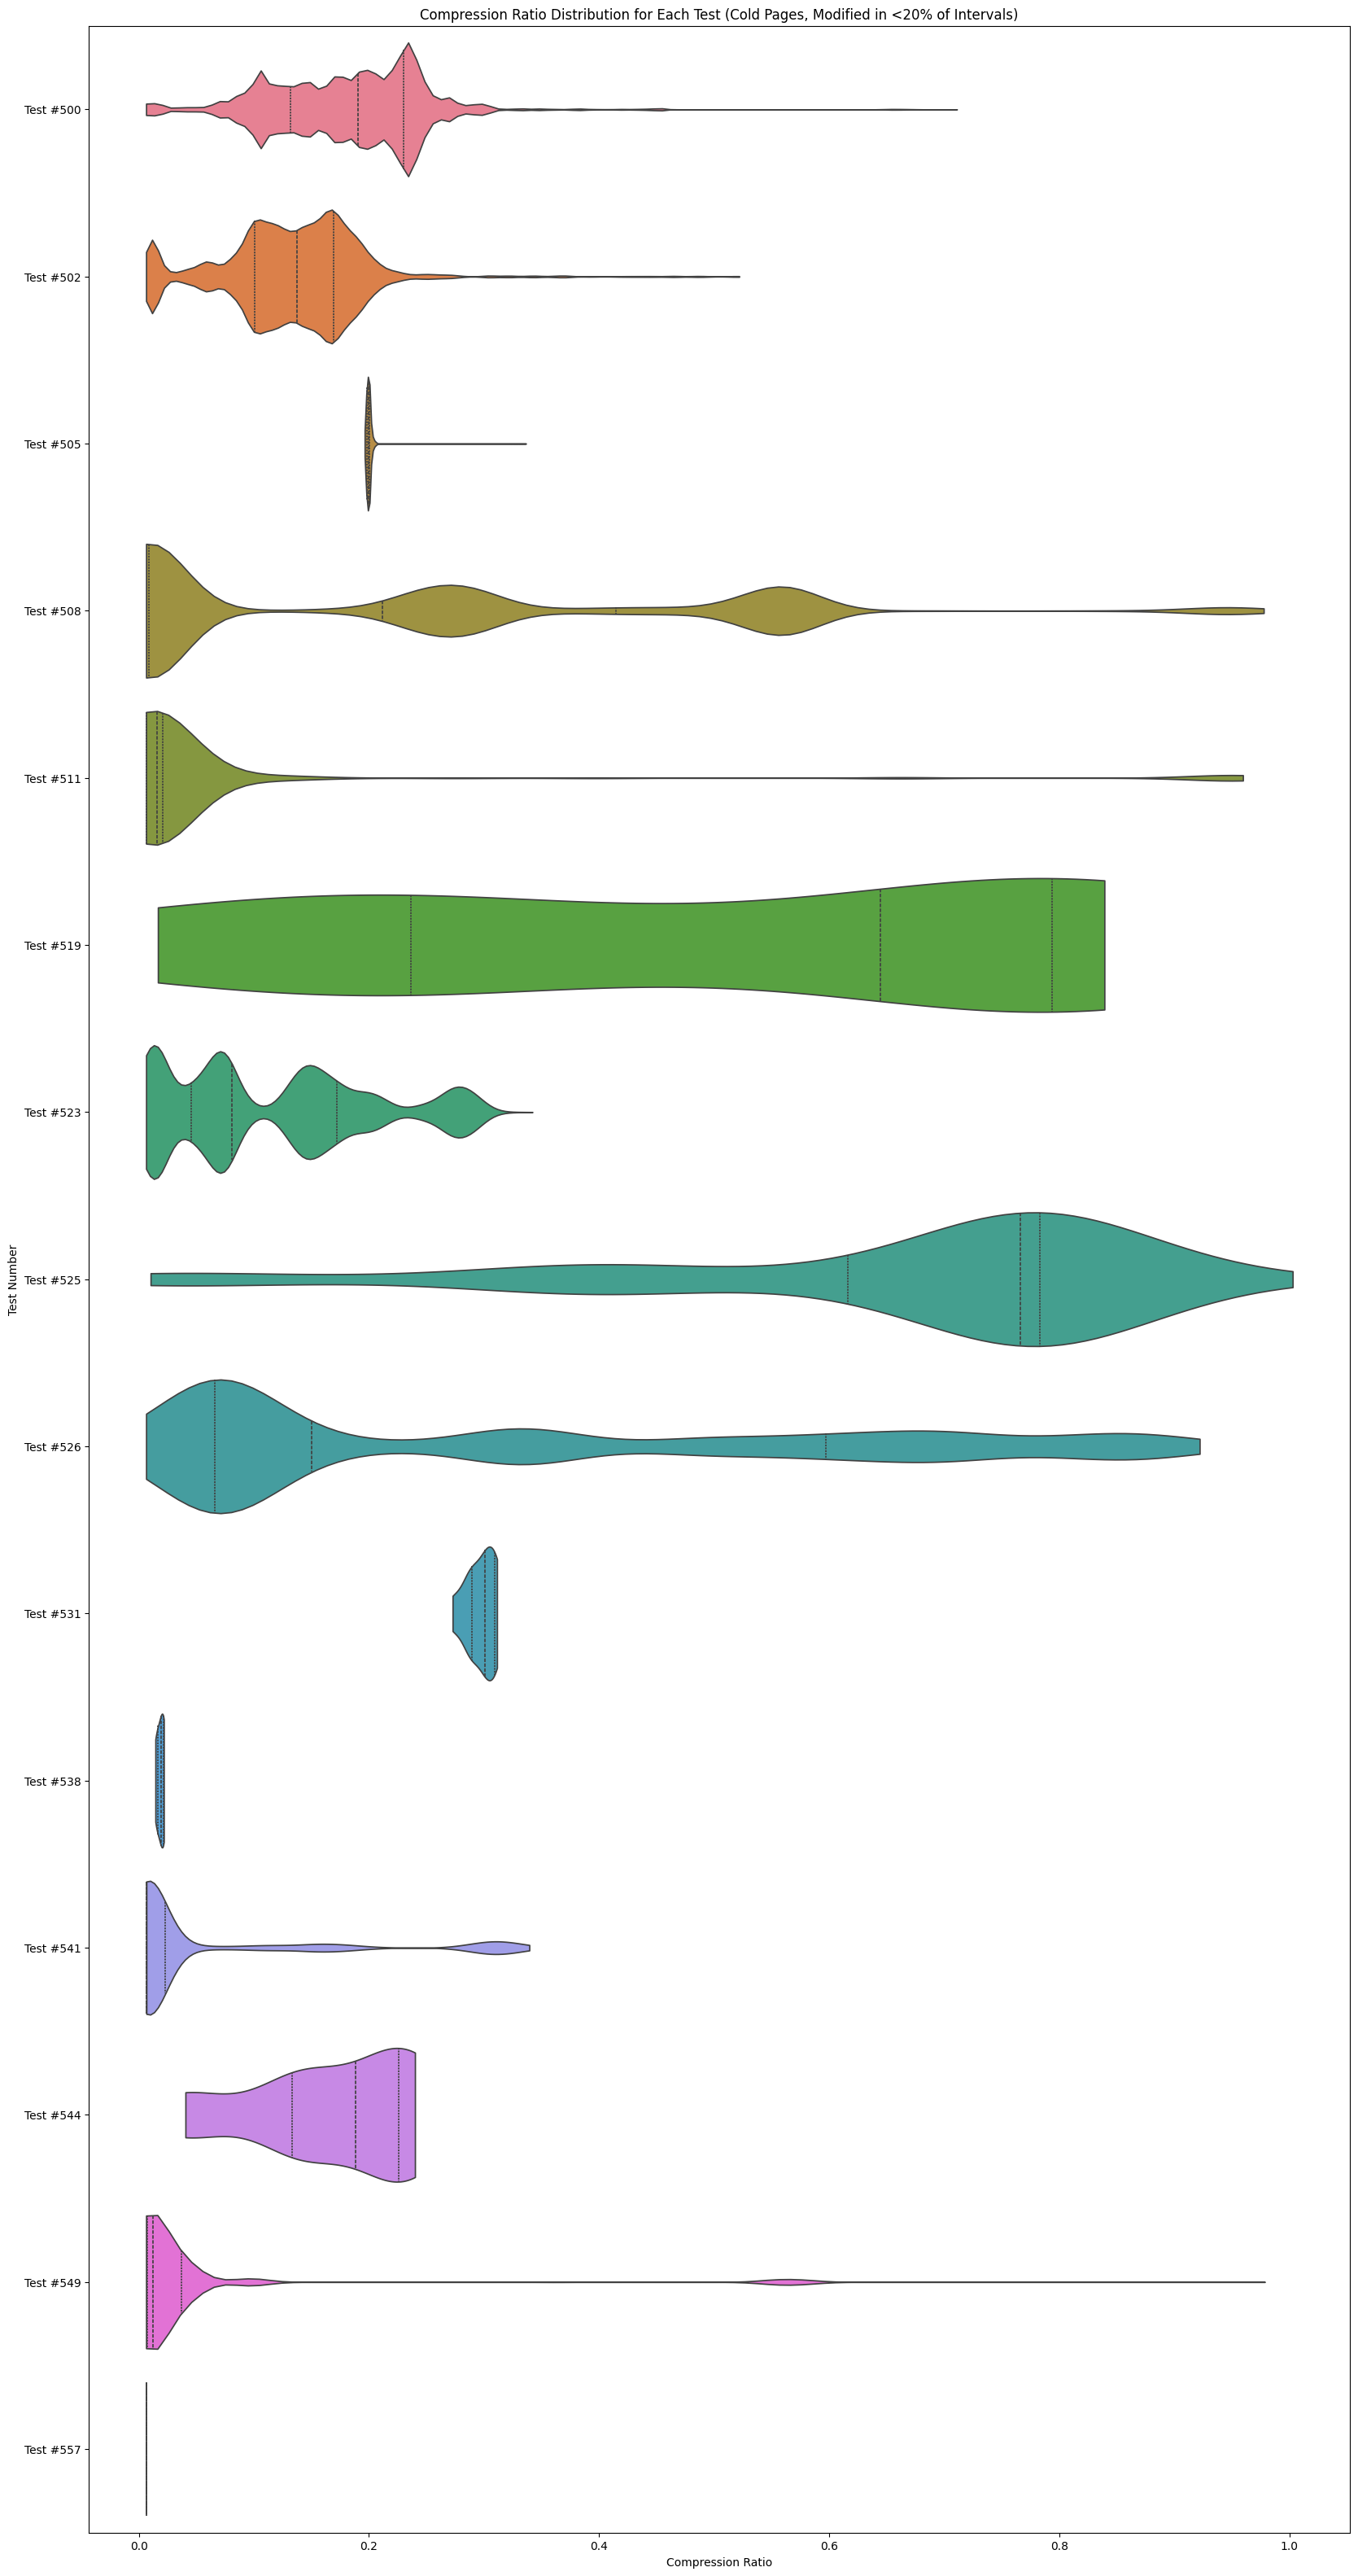

In [55]:
plt.figure(figsize=(20, 40))
# Get only the pages that are modified for less than 20% of the intervals
# intervals = all_tests["Interval #"].max()
cold_pages = all_tests.groupby("Physical Page Address").filter(lambda x: (x["Written During This Interval?"].sum() / max(x["Interval #"].max() - x["Interval #"].min(), 1)) < 0.2)

ax = sns.violinplot(data=cold_pages, cut=0, x="Compression Ratio", y="Test Number", hue="Test Number", inner="quartile")
# Label with the test number

plt.xlabel("Compression Ratio")
plt.ylabel("Test Number")
plt.title("Compression Ratio Distribution for Each Test (Cold Pages, Modified in <20% of Intervals)")
plt.show()

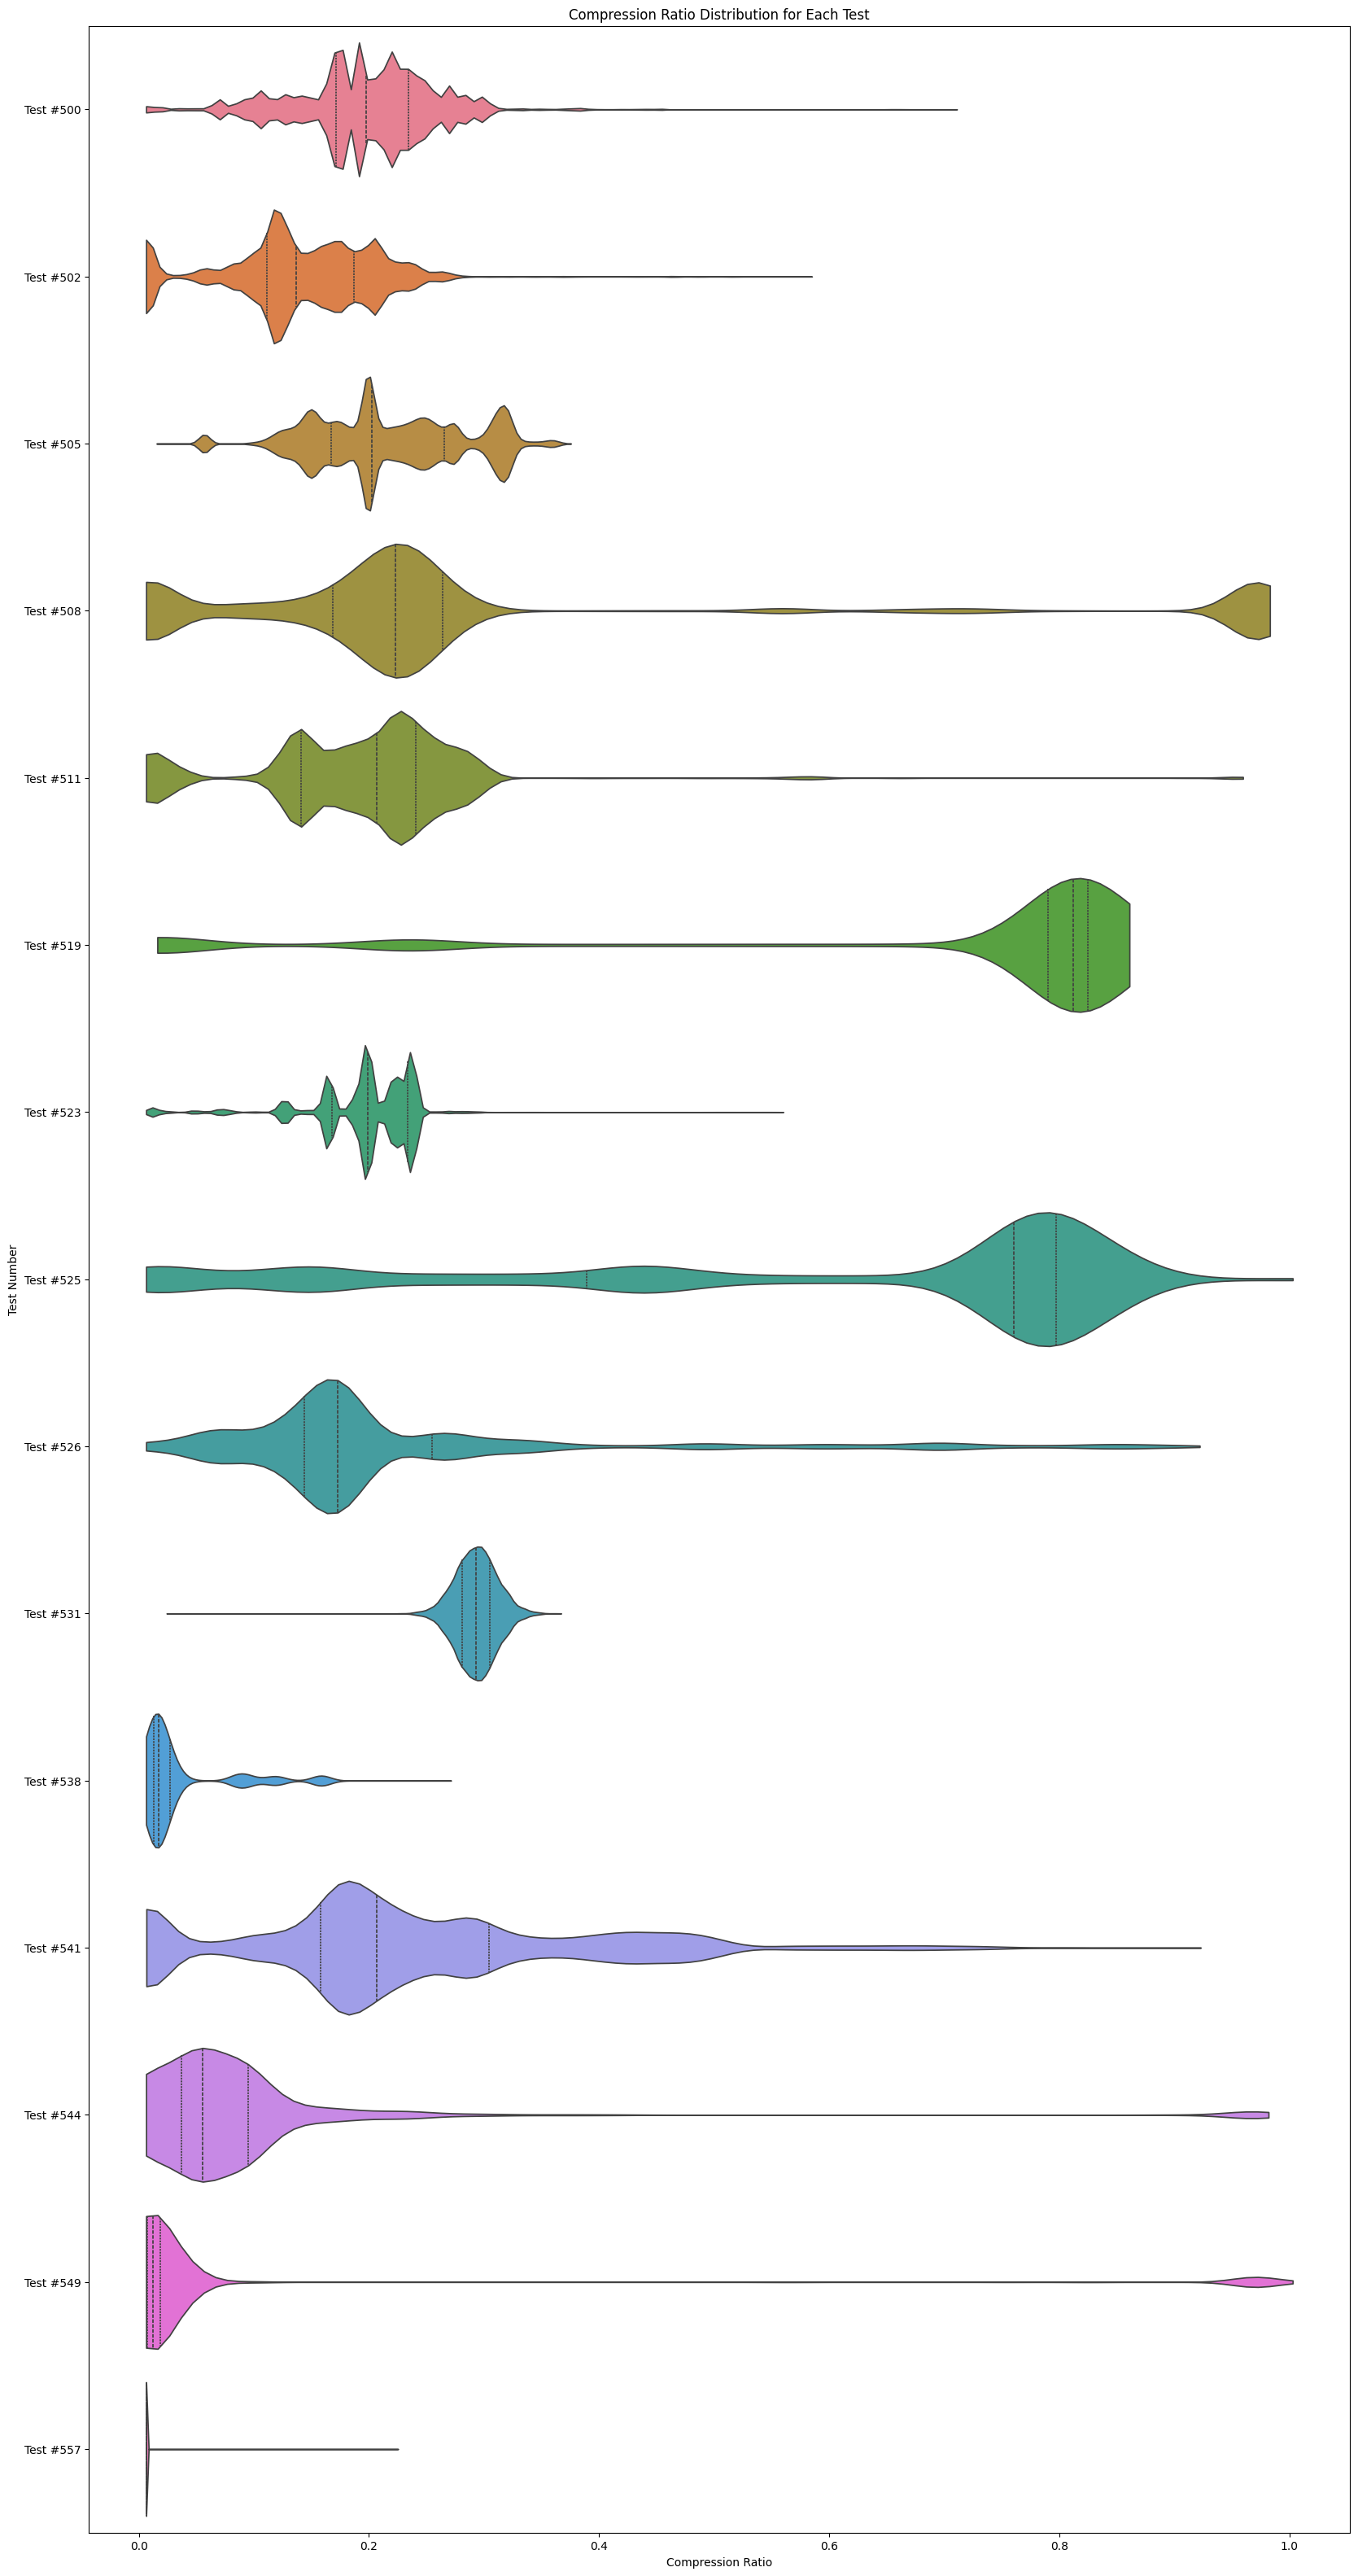

In [52]:
plt.figure(figsize=(20, 40))
ax = sns.violinplot(data=all_tests, cut=0, x="Compression Ratio", y="Test Number", hue="Test Number", inner="quartile")
# Label with the test number

plt.xlabel("Compression Ratio")
plt.ylabel("Test Number")
plt.title("Compression Ratio Distribution for Each Test")
plt.show()